# Sentiment Analysis with CNN, LSTM, Transformers

In [28]:
!pip install matplotlib
!pip install seaborn
!pip install nltk
!pip install torch
!pip install scikit-learn
!pip install WordCloud


   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 539.2/539.2 kB 6.7 MB/s eta 0:00:00


In [29]:
import pandas as pd
import re
import matplotlib.pyplot as plt
import numpy as np
import seaborn as sns
import nltk
from nltk.tokenize import word_tokenize
from nltk.corpus import stopwords
from nltk.stem import WordNetLemmatizer

from sklearn.model_selection import train_test_split
from sklearn.metrics import classification_report, accuracy_score, confusion_matrix
from sklearn.preprocessing import LabelEncoder
import torch
from tqdm import tqdm
from torch.utils.data import DataLoader, Dataset
from sklearn.feature_extraction.text import CountVectorizer
from collections import Counter
from wordcloud import WordCloud

# test by huggingface 开源 bert
from transformers import BertTokenizer, BertForSequenceClassification
from transformers import RobertaForSequenceClassification, RobertaTokenizer
from transformers import DistilBertForSequenceClassification, DistilBertTokenizer
from transformers import AutoTokenizer, AutoModelForSequenceClassification

from torch.optim import AdamW 
import torch.nn as nn
from torch.utils.data import Dataset, DataLoader
from sklearn.model_selection import train_test_split
from sklearn.metrics import accuracy_score
import pandas as pd
from collections import Counter
import re

import warnings
warnings.filterwarnings("ignore")

## Load Data

In [31]:
df = pd.read_csv('data/tripadvisor_hotel_reviews.csv', 
                 encoding="utf-8", 
                 encoding_errors="replace")
df.head()

,Review,Rating
0,nice hotel expensive parking got good deal sta...,4
1,ok nothing special charge diamond member hilto...,2
2,nice rooms not 4* experience hotel monaco seat...,3
3,"unique, great stay, wonderful time hotel monac...",5
4,"great stay great stay, went seahawk game aweso...",5


In [32]:
df.describe().round(2)

,Rating
count,20491.00
mean,3.95
std,1.23
min,1.00
25%,3.00
50%,4.00
75%,5.00
max,5.00


## Label sentiment by rating

In [33]:
# label hotel rating to label
def label_sentiment(rating):
    if rating < 3:
        return 'negative'
    elif rating >3:
        return 'positive'

df['sentiment'] = df['Rating'].apply(label_sentiment)
df.head()

,Review,Rating,sentiment
0,nice hotel expensive parking got good deal sta...,4,positive
1,ok nothing special charge diamond member hilto...,2,negative
2,nice rooms not 4* experience hotel monaco seat...,3,None
3,"unique, great stay, wonderful time hotel monac...",5,positive
4,"great stay great stay, went seahawk game aweso...",5,positive


In [36]:
# drop neutral rating
df=df.dropna(subset=['sentiment'])

## Data Visualization

In [37]:
def draw_histogram(cat, count, title="Distribution of Ratings Histogram"):
    plt.figure(figsize=(6, 4))
    barplot = sns.barplot(
        x=cat, 
        y=count, 
        dodge=False,
        palette="Set2"
    )
    # plt.legend(title=title, loc='upper right')
    plt.tight_layout()
    plt.show()


def draw_pie(cat, count, title="Distribution of Ratings Bar"):
    plt.figure(figsize=(4, 4))
    colors = plt.cm.Set3(np.linspace(0, 1, len(cat)))  # automatically fill in color
    plt.pie(
        count, 
        labels=cat, 
        autopct="%.1f%%",
        colors=colors,
        startangle=140
    )
    plt.tight_layout()
    plt.show()

def word_length_dist(df, x='word_length'):
    # Calculate the length of each review
    plt.figure(figsize=(6, 4))
    sns.histplot(df, x='word_length', hue='sentiment', multiple='stack', palette='bright', kde=True)
    plt.title('Distribution of Text Lengths by Sentiment', fontsize=16)
    plt.xlabel('Text Length')
    plt.ylabel('Frequency')
    plt.show()


def show_wordcloud(reviews, title="Word Cloud", filter_words = None):
    wc = WordCloud(
        max_words=500, 
        background_color="white",
        stopwords=filter_words).generate(" ".join(reviews))

    plt.figure(figsize=(6, 4))
    plt.imshow(wc)
    plt.title(title, fontsize=20)
    plt.axis('off')
    plt.show()
    
def word_count(df):
    vectorizer = CountVectorizer(stop_words='english', max_features=10)
    word_counts = vectorizer.fit_transform(df['Review']).toarray().sum(axis=0)
    words = vectorizer.get_feature_names_out()
    word_freq = dict(zip(words, word_counts))
    sorted_word_freq = dict(sorted(word_freq.items(), key=lambda item: item[1], reverse=True))
    
    # Plot the most common words
    plt.figure(figsize=(6, 4))
    sns.barplot(x=list(sorted_word_freq.keys()), y=list(sorted_word_freq.values()), palette='viridis')
    plt.title('Most Common Words')
    plt.xlabel('Words')
    plt.ylabel('Frequency')
    plt.xticks(rotation=45)
    plt.show()


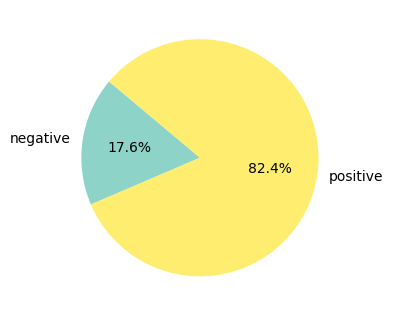

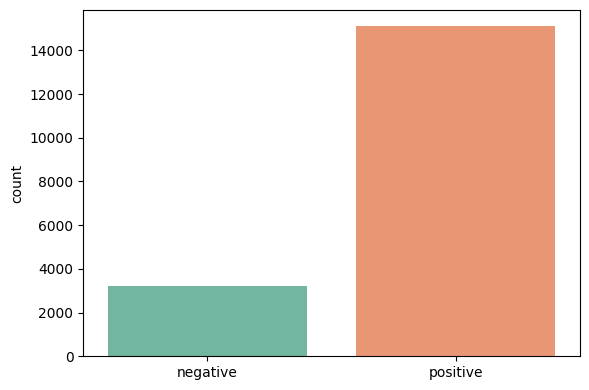

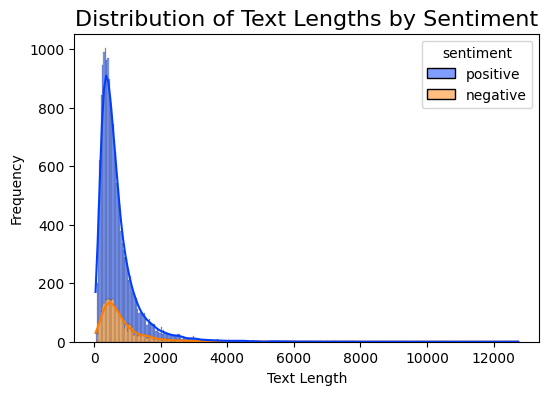

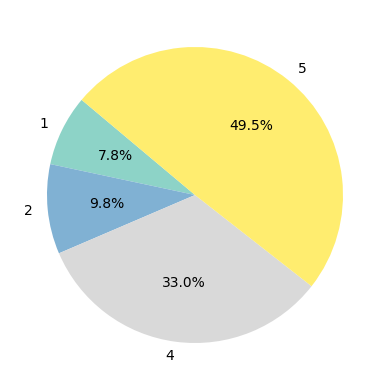

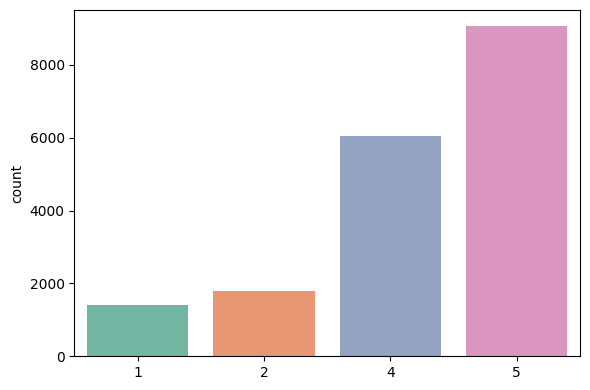

In [38]:
# visualization
df['word_length'] = df['Review'].apply(len)

sentiment_rate = df['sentiment'].value_counts(normalize=True).sort_index()

colors = sns.color_palette("viridis", len(sentiment_rate))
labels = [f"{label}" for label in sentiment_rate.index]

draw_pie(labels, sentiment_rate)
draw_histogram(labels, df['sentiment'].value_counts().sort_index())
word_length_dist(df)


# rating
ratings_count = df['Rating'].value_counts(normalize=True).mul(100).sort_index()
rates = [f"{rate}" for rate in ratings_count.index]

draw_pie(rates, ratings_count)
draw_histogram(rates, df['Rating'].value_counts().sort_index())


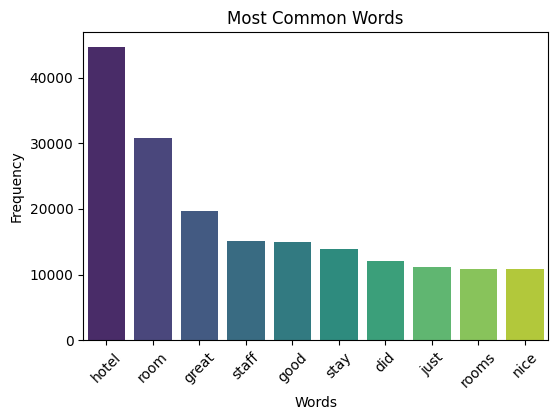

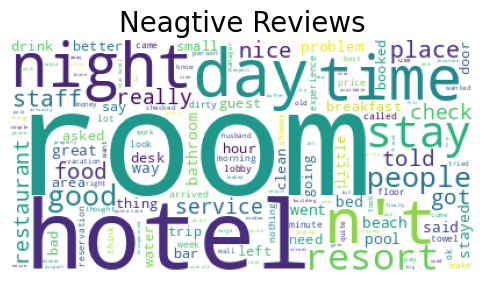

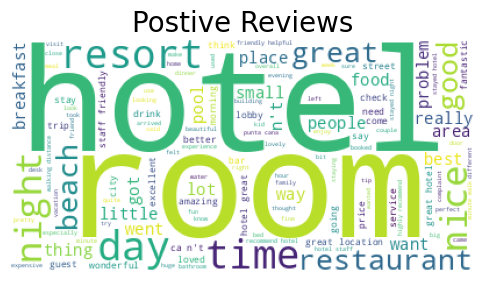

In [39]:
word_count(df)

show_wordcloud(df[df["sentiment"] == "negative"]["Review"], title="Neagtive Reviews")
show_wordcloud(df[df["sentiment"] == "positive"]["Review"], title="Postive Reviews")

In [ ]:
df.info()


<class 'pandas.core.frame.DataFrame'>
Index: 18307 entries, 0 to 20490
Data columns (total 4 columns):
 #   Column       Non-Null Count  Dtype 
---  ------       --------------  ----- 
 0   Review       18307 non-null  object
 1   Rating       18307 non-null  int64 
 2   sentiment    18307 non-null  object
 3   word_length  18307 non-null  int64 
dtypes: int64(2), object(2)
memory usage: 715.1+ KB


## Text Preprocessing Pipeline

In [13]:
# Download required NLTK data
nltk.download('punkt')
nltk.download('stopwords')
nltk.download('wordnet')
nltk.download('punkt_tab')

[nltk_data] Downloading package punkt to
[nltk_data]     C:\Users\HW\AppData\Roaming\nltk_data...
[nltk_data]   Package punkt is already up-to-date!
[nltk_data] Downloading package stopwords to
[nltk_data]     C:\Users\HW\AppData\Roaming\nltk_data...
[nltk_data]   Package stopwords is already up-to-date!
[nltk_data] Downloading package wordnet to
[nltk_data]     C:\Users\HW\AppData\Roaming\nltk_data...
[nltk_data]   Package wordnet is already up-to-date!
[nltk_data] Downloading package punkt_tab to
[nltk_data]     C:\Users\HW\AppData\Roaming\nltk_data...
[nltk_data]   Package punkt_tab is already up-to-date!


True

In [ ]:
def preprocess_data(df_data):
    """
    Preprocesses a DataFrame by cleaning and preparing text data in the 'Review' column.

    Steps:
    1. Remove duplicates and rows with missing values.
    2. Clean 'Review' column:
       - Strip whitespace.
       - Remove non-alphabetic characters (except spaces).
       - Replace newlines with spaces.
       - Convert to lowercase.
       - Remove URLs.
       - Normalize spaces.
    3. Remove rows with empty 'Review' after cleaning.
    4. Reset index.

    Args:
        df_data (pd.DataFrame): Input DataFrame with 'Review' and 'Rating' columns.
    Returns:
        pd.DataFrame: Cleaned DataFrame.
    """
    # df = df_data.dropna().copy()
    # print(df_data.shape)
    # print(df.shape)
    
    df = df_data.copy()
    df['Review'] = (df_data['Review']
        .str.strip()
        .str.replace(r'\n', ' ', regex=True)
        .str.lower()
        .apply(lambda x: re.sub(r'http\S+|www.\S+', '', x))
        .apply(lambda x: re.sub(r'[^a-z\s]', '', x))
        .apply(lambda x: ' '.join(x.split()))
    )
    df = df[df['Review'].str.len() > 0].reset_index(drop=True)
    df = df[df['word_length'] <= 2000]
    return df

# print(df['Review'].isna().sum())
# print(df['sentiment'].isna().sum())
# df[df[['Review','airline']].duplicated()]
# new_df = preprocess_data(df)
# display(df.shape)
# display(new_df.shape)

def tokenize_text(df):
    """
    Tokenizes the text in the 'Review' column of the DataFrame.

    Args:
        df (pd.DataFrame): DataFrame containing a 'Review' column.

    Returns:
        pd.DataFrame: DataFrame with a new 'tokens' column containing tokenized words.
    """
    df['tokens'] = df['Review'].apply(lambda review: word_tokenize(review))
    return df

def remove_stopwords(df):
    """
    Removes stopwords from the tokenized text in the 'tokens' column.

    Args:
        df (pd.DataFrame): DataFrame with a 'tokens' column.

    Returns:
        pd.DataFrame: DataFrame with a new 'tokens_no_stop' column containing tokens without stopwords.
    """
    stop_words = set(stopwords.words('english'))
    df['tokens_no_stop'] = df['tokens'].apply(
        lambda tokens: [word for word in tokens if word.lower() not in stop_words]
    )
    return df

# pos_tags = pos_tag(tokens)  # get speech
# lemmatized = [lemmatizer.lemmatize(word, get_wordnet_pos(pos)) for word, pos in pos_tags]
def lemmatize_text(df):
    """
    Lemmatizes the tokens in the 'tokens_no_stop' column.

    Args:
        df (pd.DataFrame): DataFrame with a 'tokens_no_stop' column.

    Returns:
        pd.DataFrame: DataFrame with a new 'lemmatized' column containing lemmatized tokens.
    """
    lemmatizer = WordNetLemmatizer()
    df['lemmatized'] = df['tokens_no_stop'].apply(
        lambda tokens: [lemmatizer.lemmatize(word) for word in tokens]
    )
    return df

def join_tokens(df):
    """
    Joins the lemmatized tokens back into a single string.

    Args:
        df (pd.DataFrame): DataFrame with a 'lemmatized' column.
    Returns:
        pd.DataFrame: DataFrame with a new 'processed_text' column containing the joined text.
    """
    df['processed_text'] = df['lemmatized'].apply(
        lambda tokens: ' '.join(tokens)
    )
    return df

In [15]:
df = (
    preprocess_data(df)
    .pipe(tokenize_text)
    .pipe(remove_stopwords)
    .pipe(lemmatize_text)
    .pipe(join_tokens)
)

In [16]:
# check data shape, postive/negative rate after preprocess

df = df[df['sentiment'].isin(["positive", "negative"])]
display(df.head(3))
print(df.shape)

print(df['processed_text'].isna().sum())
print(df['sentiment'].isna().sum())


sentiment_rate = df['sentiment'].value_counts(normalize=True).sort_index()
sentiment_rate

,Review,Rating,sentiment,word_length,tokens,tokens_no_stop,lemmatized,processed_text
0,nice hotel expensive parking got good deal sta...,4,positive,593,"[nice, hotel, expensive, parking, got, good, d...","[nice, hotel, expensive, parking, got, good, d...","[nice, hotel, expensive, parking, got, good, d...",nice hotel expensive parking got good deal sta...
1,ok nothing special charge diamond member hilto...,2,negative,1689,"[ok, nothing, special, charge, diamond, member...","[ok, nothing, special, charge, diamond, member...","[ok, nothing, special, charge, diamond, member...",ok nothing special charge diamond member hilto...
2,unique great stay wonderful time hotel monaco ...,5,positive,600,"[unique, great, stay, wonderful, time, hotel, ...","[unique, great, stay, wonderful, time, hotel, ...","[unique, great, stay, wonderful, time, hotel, ...",unique great stay wonderful time hotel monaco ...


(17515, 8)
0
0


sentiment
negative    0.172538
positive    0.827462
Name: proportion, dtype: float64

# Sentiment Analysis Model

In [17]:
sentiment_rate = df['sentiment'].value_counts(normalize=True).sort_index()
labels = [f"{label}" for label in sentiment_rate.index]
labels

['negative', 'positive']

In [ ]:
def plot_confusion_matrix(y_true, y_pred, labels=None, cmap="Blues"):
    cm = confusion_matrix(y_true, y_pred)
    cm = cm.astype("float") / cm.sum(axis=1, keepdims=True)
    plt.figure(figsize=(6, 5))
    sns.heatmap(cm, annot=True, fmt=".2f", cmap=cmap, xticklabels=labels, yticklabels=labels)
    plt.xlabel("Predicted")
    plt.ylabel("Actual")
    plt.title("Normalized Confusion Matrix")
    plt.show()


def plot_auc(pred_nb, y_test):
    from sklearn.metrics import auc, f1_score, precision_recall_curve, recall_score, roc_curve, precision_score
    
    fpr, tpr, _ = roc_curve(y_test, pred_nb)
    precision, recall, _ = precision_recall_curve(y_test, pred_nb)
    
    roc_auc = auc(fpr, tpr)
    pr_auc = auc(recall, precision)
    
    plt.plot(fpr, tpr, label='ROC Curve (AUC = {:.5f})'.format(roc_auc))
    plt.plot(recall, precision, label='PR Curve (AUC = {:.5f})'.format(pr_auc))
    
    
    plt.plot([0, 1], [0, 1], linestyle='--', label='Random', color='gray')
    
    # setting axis ,limits and label
    plt.xlim([0.0, 1.0])
    plt.ylim([0.0, 1.05])
    plt.xlabel('False Positive Rate / Recall')
    plt.ylabel('True Positive Rate / Precision')
    plt.title('PR-ROC ')
    plt.legend(loc='lower right')
    # plt.savefig('PR-ROC Curve.png')
    
    plt.show()

def model_eval(model_name, y_pred, y_test):
    print(f"{model_name} Accuracy: {accuracy_score(y_test, y_pred) * 100:.2f} %")
    report = classification_report(y_test, y_pred, zero_division=0)
    print(report)
    plot_confusion_matrix(y_test, y_pred, labels)
    return report

def draw_bar(acc, pre, recall):

    metrics = ['Accuracy', 'Precision', 'Recall']
    values = [acc, pre, recall]  

    plt.figure(figsize=(8, 6))
    bars = plt.bar(metrics, values, color=['blue', 'green', 'red'])

    for bar in bars:
        height = bar.get_height()
        plt.text(bar.get_x() + bar.get_width()/2., height,
                f'{height:.2f}',
                ha='center', va='bottom')

    plt.title('Classification Metrics', fontsize=14)
    plt.ylabel('Score', fontsize=12)
    plt.ylim(0, 1.1)  

    plt.grid(axis='y', linestyle='--', alpha=0.7)
    plt.tight_layout()
    plt.show()

# Transformer

In [67]:
import torch
print(torch.cuda.is_available())
print(torch.version.cuda)
print(torch.cuda.get_device_name(0))

True
12.1
NVIDIA GeForce RTX 4060 Laptop GPU


In [21]:
class SentimentDataset(Dataset):
    def __init__(self, texts, labels, tokenizer, max_len=512):
        self.texts = texts
        self.labels = labels
        self.tokenizer = tokenizer
        self.max_len = max_len

    def __len__(self):
        return len(self.texts)

    def __getitem__(self, item):
        texts = str(self.texts[item])
        labels = self.labels[item]

        # text to vector
        encoding = self.tokenizer.encode_plus(
            texts,
            add_special_tokens=True,
            max_length=self.max_len,
            return_token_type_ids=False,
            padding='max_length',
            truncation=True,
            return_attention_mask=True,
            return_tensors='pt'
        )

        input_ids = encoding['input_ids'].flatten()
        attention_mask = encoding['attention_mask'].flatten()
        
        return {
            'input_ids': input_ids,
            'attention_mask': attention_mask,
            'labels': torch.tensor(labels, dtype=torch.long)
        }

In [22]:
from transformers import DataCollatorWithPadding
def create_dataloaders(train_df, test_df, tokenizer, label = 'sentiment', batch_size=8):
    data_collator = DataCollatorWithPadding(tokenizer)
    # train_loader = DataLoader(dataset, batch_size=8, collate_fn=data_collator)
    
    train_dataset = SentimentDataset(train_df["processed_text"].tolist(), train_df[label].tolist(), tokenizer)
    test_dataset = SentimentDataset(test_df["processed_text"].tolist(), test_df[label].tolist(), tokenizer)
    
    train_loader = DataLoader(train_dataset, batch_size=batch_size, shuffle=True, collate_fn=data_collator)
    test_loader = DataLoader(test_dataset, batch_size=batch_size, shuffle=False, collate_fn=data_collator)
    return train_loader, test_loader

In [ ]:
def train_epoch(model, optimizer, device, train_loader, epoch):
    model.train()
    running_loss = 0.0
    correct = 0
    total = 0

    optimizer.zero_grad()
    progress_bar = tqdm(train_loader, desc=f"训练中 {epoch}")
    for i, batch in enumerate(progress_bar):
        input_ids, attention_mask, labels = (
            batch[k].to(device) for k in ["input_ids", "attention_mask", "labels"]
        )
        # print(f"label = {labels}")
        outputs = model(input_ids, attention_mask=attention_mask, labels=labels)
        loss = outputs.loss
        loss.backward()
        
        # Gradient clipping to avoid gradient explosion
        # nn.utils.clip_grad_norm_(self.model.parameters(), max_norm=5.0)
  
        optimizer.step()
        optimizer.zero_grad()
        
        # total_loss += loss.item()

     
        running_loss += loss.item()
        # _, predicted = outputs.max(1)
        predicted = torch.argmax(outputs.logits, dim=1)
        total += labels.size(0)
        correct += predicted.eq(labels).sum().item()
        
        # update progress bar
        progress_bar.set_postfix({
            'loss': running_loss / (progress_bar.n + 1),
            'acc': 100. * correct / total
        })
    
    epoch_loss = running_loss / len(train_loader)
    epoch_acc = 100. * correct / total
    return epoch_loss, epoch_acc

from sklearn.metrics import accuracy_score
def evaluate2(model, device, test_loader):
    model.eval()
    total_loss = 0
    all_preds = []
    all_labels = []

    with torch.no_grad():
        for batch in tqdm(test_loader, desc="Evaluating"):
            input_ids, attention_mask, labels = (
                batch[k].to(device) for k in ["input_ids", "attention_mask", "labels"]
            )

            outputs = model(input_ids, attention_mask=attention_mask, labels=labels)
            loss = outputs.loss
            logits = outputs.logits

            total_loss += loss.item()
            preds = torch.argmax(logits, dim=1)
            all_preds.extend(preds.cpu().numpy())
            all_labels.extend(labels.cpu().numpy())

    avg_loss = total_loss / len(test_loader)
    acc = accuracy_score(all_labels, all_preds)

    return all_preds, all_labels, avg_loss, acc*100.


def train(model, 
          train_loader, 
          test_loader, 
          num_epochs=3, 
          # learning_rate=2e-5, 
          learning_rate=0.001,
          save_path="model.pth",
          target_names = ["negative", "neutral", "positive"],
          fine_tuning = False):
    
     # move to the specified device
    device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
    model.to(device)

    history = {}
    train_losses = []
    train_accuracies = []
    val_losses = []
    val_accuracies = []
    
    if fine_tuning:
        for layer in model.distilbert.transformer.layer[:4]:
            for param in layer.parameters():
                param.requires_grad = False
        optimizer = torch.optim.AdamW(model.classifier.parameters(), lr=learning_rate)
    else:
        optimizer = AdamW(model.parameters(), lr=learning_rate)

    scheduler = torch.optim.lr_scheduler.ReduceLROnPlateau(optimizer, 'min', patience=2, factor=0.5, verbose=True)
    
    for epoch in range(1, num_epochs + 1):
        # train
        train_loss, train_acc = train_epoch(model, optimizer, device, train_loader, epoch)
        train_losses.append(train_loss)
        train_accuracies.append(train_acc)

        test_preds, test_true,  val_loss, val_acc = evaluate2(model, device, test_loader)
        val_losses.append(val_loss)
        val_accuracies.append(val_acc)

        # adjust lr
        scheduler.step(train_loss)
        
        history = {
            'train_losses': train_losses,
            'train_accuracies': train_accuracies,
            'val_losses': val_losses,
            'val_accuracies': val_accuracies
        }
        print(
            "Classification Report:\n",
            classification_report(
                test_true, test_preds, target_names=target_names
            ),
        )

    # Save model
    print(f"\nSaving model...{save_path}")
    torch.save(
        {
            "model_state_dict": model.state_dict(),
            "optimizer_state_dict": optimizer.state_dict()
        },
        save_path,
    )
    return history


In [30]:
# distilbert-base-uncased
tokenizer_hotel = AutoTokenizer.from_pretrained('distilbert-base-uncased')
model_hotel = AutoModelForSequenceClassification.from_pretrained('distilbert-base-uncased', num_labels=2)

Some weights of DistilBertForSequenceClassification were not initialized from the model checkpoint at distilbert-base-uncased and are newly initialized: ['classifier.bias', 'classifier.weight', 'pre_classifier.bias', 'pre_classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


In [ ]:
# encode label
df['sentiment_encode'] = LabelEncoder().fit_transform(df['sentiment'].dropna())
print(df['sentiment_encode'].value_counts())

train_df_hotel, test_df_hotel = train_test_split(
    df, test_size=0.1, random_state=42, stratify=df['sentiment_encode']
)

train_loader_hotel, test_loader_hotel = create_dataloaders(train_df_hotel, test_df_hotel, 
                                                           tokenizer_hotel, label = 'sentiment_encode',   
                                                           batch_size = 16)

sentiment_encode
1    14493
0     3022
Name: count, dtype: int64


In [ ]:
history_hotel = train(model_hotel, 
      train_loader_hotel, 
      test_loader_hotel, 
      save_path="distil_bert_hotel.pth", 
      fine_tuning = True,
      # target_names = ['negative', 'neutral', 'positive'],
      target_names = ['negative', 'positive'],
      num_epochs=50
     )

Evaluating: 100%|██████████| 229/229 [00:08<00:00, 28.09it/s]


Classification Report:
               precision    recall  f1-score   support

    negative       0.92      0.57      0.71       321
    positive       0.92      0.99      0.95      1510

    accuracy                           0.92      1831
   macro avg       0.92      0.78      0.83      1831
weighted avg       0.92      0.92      0.91      1831



Evaluating: 100%|██████████| 229/229 [00:08<00:00, 27.88it/s]


Classification Report:
               precision    recall  f1-score   support

    negative       0.89      0.61      0.72       321
    positive       0.92      0.98      0.95      1510

    accuracy                           0.92      1831
   macro avg       0.91      0.80      0.84      1831
weighted avg       0.92      0.92      0.91      1831



Evaluating: 100%|██████████| 229/229 [00:08<00:00, 27.68it/s]


Classification Report:
               precision    recall  f1-score   support

    negative       0.95      0.51      0.66       321
    positive       0.90      0.99      0.95      1510

    accuracy                           0.91      1831
   macro avg       0.93      0.75      0.81      1831
weighted avg       0.91      0.91      0.90      1831



Evaluating: 100%|██████████| 229/229 [00:08<00:00, 28.17it/s]


Classification Report:
               precision    recall  f1-score   support

    negative       0.88      0.67      0.76       321
    positive       0.93      0.98      0.96      1510

    accuracy                           0.93      1831
   macro avg       0.91      0.83      0.86      1831
weighted avg       0.92      0.93      0.92      1831



Evaluating: 100%|██████████| 229/229 [00:08<00:00, 27.93it/s]


Classification Report:
               precision    recall  f1-score   support

    negative       0.88      0.69      0.78       321
    positive       0.94      0.98      0.96      1510

    accuracy                           0.93      1831
   macro avg       0.91      0.84      0.87      1831
weighted avg       0.93      0.93      0.93      1831



Evaluating: 100%|██████████| 229/229 [00:08<00:00, 28.07it/s]


Classification Report:
               precision    recall  f1-score   support

    negative       0.82      0.76      0.79       321
    positive       0.95      0.96      0.96      1510

    accuracy                           0.93      1831
   macro avg       0.88      0.86      0.87      1831
weighted avg       0.93      0.93      0.93      1831



Evaluating: 100%|██████████| 229/229 [00:08<00:00, 27.70it/s]


Classification Report:
               precision    recall  f1-score   support

    negative       0.90      0.66      0.76       321
    positive       0.93      0.98      0.96      1510

    accuracy                           0.93      1831
   macro avg       0.92      0.82      0.86      1831
weighted avg       0.93      0.93      0.92      1831



Evaluating: 100%|██████████| 229/229 [00:08<00:00, 28.27it/s]


Classification Report:
               precision    recall  f1-score   support

    negative       0.91      0.60      0.72       321
    positive       0.92      0.99      0.95      1510

    accuracy                           0.92      1831
   macro avg       0.91      0.79      0.84      1831
weighted avg       0.92      0.92      0.91      1831



Evaluating: 100%|██████████| 229/229 [00:08<00:00, 28.22it/s]


Classification Report:
               precision    recall  f1-score   support

    negative       0.87      0.70      0.78       321
    positive       0.94      0.98      0.96      1510

    accuracy                           0.93      1831
   macro avg       0.90      0.84      0.87      1831
weighted avg       0.93      0.93      0.93      1831



Evaluating: 100%|██████████| 229/229 [00:08<00:00, 28.10it/s]


Classification Report:
               precision    recall  f1-score   support

    negative       0.89      0.66      0.76       321
    positive       0.93      0.98      0.96      1510

    accuracy                           0.93      1831
   macro avg       0.91      0.82      0.86      1831
weighted avg       0.92      0.93      0.92      1831



Evaluating: 100%|██████████| 229/229 [00:08<00:00, 28.04it/s]


Classification Report:
               precision    recall  f1-score   support

    negative       0.90      0.64      0.74       321
    positive       0.93      0.98      0.96      1510

    accuracy                           0.92      1831
   macro avg       0.91      0.81      0.85      1831
weighted avg       0.92      0.92      0.92      1831



Evaluating: 100%|██████████| 229/229 [00:08<00:00, 28.37it/s]


Classification Report:
               precision    recall  f1-score   support

    negative       0.90      0.64      0.74       321
    positive       0.93      0.98      0.96      1510

    accuracy                           0.92      1831
   macro avg       0.91      0.81      0.85      1831
weighted avg       0.92      0.92      0.92      1831



Evaluating: 100%|██████████| 229/229 [00:08<00:00, 28.08it/s]


Classification Report:
               precision    recall  f1-score   support

    negative       0.88      0.69      0.77       321
    positive       0.94      0.98      0.96      1510

    accuracy                           0.93      1831
   macro avg       0.91      0.83      0.86      1831
weighted avg       0.93      0.93      0.93      1831



Evaluating: 100%|██████████| 229/229 [00:08<00:00, 28.03it/s]


Classification Report:
               precision    recall  f1-score   support

    negative       0.90      0.62      0.74       321
    positive       0.92      0.99      0.95      1510

    accuracy                           0.92      1831
   macro avg       0.91      0.80      0.84      1831
weighted avg       0.92      0.92      0.92      1831



Evaluating: 100%|██████████| 229/229 [00:08<00:00, 27.78it/s]


Classification Report:
               precision    recall  f1-score   support

    negative       0.92      0.60      0.73       321
    positive       0.92      0.99      0.95      1510

    accuracy                           0.92      1831
   macro avg       0.92      0.80      0.84      1831
weighted avg       0.92      0.92      0.91      1831



Evaluating: 100%|██████████| 229/229 [00:08<00:00, 27.85it/s]


Classification Report:
               precision    recall  f1-score   support

    negative       0.89      0.68      0.77       321
    positive       0.93      0.98      0.96      1510

    accuracy                           0.93      1831
   macro avg       0.91      0.83      0.86      1831
weighted avg       0.93      0.93      0.92      1831



Evaluating: 100%|██████████| 229/229 [00:08<00:00, 27.84it/s]


Classification Report:
               precision    recall  f1-score   support

    negative       0.88      0.69      0.77       321
    positive       0.94      0.98      0.96      1510

    accuracy                           0.93      1831
   macro avg       0.91      0.83      0.87      1831
weighted avg       0.93      0.93      0.93      1831



Evaluating: 100%|██████████| 229/229 [00:08<00:00, 28.24it/s]


Classification Report:
               precision    recall  f1-score   support

    negative       0.87      0.70      0.78       321
    positive       0.94      0.98      0.96      1510

    accuracy                           0.93      1831
   macro avg       0.90      0.84      0.87      1831
weighted avg       0.93      0.93      0.93      1831



Evaluating: 100%|██████████| 229/229 [00:08<00:00, 28.20it/s]


Classification Report:
               precision    recall  f1-score   support

    negative       0.87      0.70      0.78       321
    positive       0.94      0.98      0.96      1510

    accuracy                           0.93      1831
   macro avg       0.91      0.84      0.87      1831
weighted avg       0.93      0.93      0.93      1831



Evaluating: 100%|██████████| 229/229 [00:08<00:00, 27.94it/s]


Classification Report:
               precision    recall  f1-score   support

    negative       0.91      0.62      0.73       321
    positive       0.92      0.99      0.95      1510

    accuracy                           0.92      1831
   macro avg       0.92      0.80      0.84      1831
weighted avg       0.92      0.92      0.92      1831



Evaluating: 100%|██████████| 229/229 [00:08<00:00, 27.96it/s]


Classification Report:
               precision    recall  f1-score   support

    negative       0.89      0.68      0.77       321
    positive       0.93      0.98      0.96      1510

    accuracy                           0.93      1831
   macro avg       0.91      0.83      0.86      1831
weighted avg       0.93      0.93      0.92      1831



Evaluating: 100%|██████████| 229/229 [00:08<00:00, 27.80it/s]


Classification Report:
               precision    recall  f1-score   support

    negative       0.90      0.63      0.74       321
    positive       0.93      0.99      0.95      1510

    accuracy                           0.92      1831
   macro avg       0.91      0.81      0.85      1831
weighted avg       0.92      0.92      0.92      1831



Evaluating: 100%|██████████| 229/229 [00:08<00:00, 27.82it/s]


Classification Report:
               precision    recall  f1-score   support

    negative       0.86      0.71      0.78       321
    positive       0.94      0.98      0.96      1510

    accuracy                           0.93      1831
   macro avg       0.90      0.84      0.87      1831
weighted avg       0.93      0.93      0.93      1831



Evaluating: 100%|██████████| 229/229 [00:08<00:00, 28.30it/s]


Classification Report:
               precision    recall  f1-score   support

    negative       0.90      0.64      0.75       321
    positive       0.93      0.99      0.96      1510

    accuracy                           0.93      1831
   macro avg       0.92      0.81      0.85      1831
weighted avg       0.92      0.93      0.92      1831



Evaluating: 100%|██████████| 229/229 [00:08<00:00, 27.73it/s]


Classification Report:
               precision    recall  f1-score   support

    negative       0.88      0.69      0.77       321
    positive       0.94      0.98      0.96      1510

    accuracy                           0.93      1831
   macro avg       0.91      0.83      0.87      1831
weighted avg       0.93      0.93      0.93      1831



Evaluating: 100%|██████████| 229/229 [00:08<00:00, 27.71it/s]


Classification Report:
               precision    recall  f1-score   support

    negative       0.90      0.66      0.76       321
    positive       0.93      0.98      0.96      1510

    accuracy                           0.93      1831
   macro avg       0.91      0.82      0.86      1831
weighted avg       0.93      0.93      0.92      1831



Evaluating: 100%|██████████| 229/229 [00:08<00:00, 28.17it/s]


Classification Report:
               precision    recall  f1-score   support

    negative       0.90      0.67      0.77       321
    positive       0.93      0.98      0.96      1510

    accuracy                           0.93      1831
   macro avg       0.91      0.83      0.86      1831
weighted avg       0.93      0.93      0.92      1831



Evaluating: 100%|██████████| 229/229 [00:08<00:00, 27.76it/s]


Classification Report:
               precision    recall  f1-score   support

    negative       0.89      0.69      0.77       321
    positive       0.94      0.98      0.96      1510

    accuracy                           0.93      1831
   macro avg       0.91      0.83      0.87      1831
weighted avg       0.93      0.93      0.93      1831



Evaluating: 100%|██████████| 229/229 [00:08<00:00, 28.20it/s]


Classification Report:
               precision    recall  f1-score   support

    negative       0.89      0.69      0.78       321
    positive       0.94      0.98      0.96      1510

    accuracy                           0.93      1831
   macro avg       0.91      0.83      0.87      1831
weighted avg       0.93      0.93      0.93      1831



Evaluating: 100%|██████████| 229/229 [00:08<00:00, 28.31it/s]


Classification Report:
               precision    recall  f1-score   support

    negative       0.90      0.62      0.74       321
    positive       0.92      0.99      0.95      1510

    accuracy                           0.92      1831
   macro avg       0.91      0.80      0.84      1831
weighted avg       0.92      0.92      0.92      1831



Evaluating: 100%|██████████| 229/229 [00:08<00:00, 28.06it/s]


Classification Report:
               precision    recall  f1-score   support

    negative       0.90      0.64      0.75       321
    positive       0.93      0.99      0.96      1510

    accuracy                           0.92      1831
   macro avg       0.92      0.81      0.85      1831
weighted avg       0.92      0.92      0.92      1831



Evaluating: 100%|██████████| 229/229 [00:08<00:00, 28.10it/s]


Classification Report:
               precision    recall  f1-score   support

    negative       0.90      0.67      0.76       321
    positive       0.93      0.98      0.96      1510

    accuracy                           0.93      1831
   macro avg       0.91      0.83      0.86      1831
weighted avg       0.93      0.93      0.92      1831



Evaluating: 100%|██████████| 229/229 [00:08<00:00, 28.05it/s]


Classification Report:
               precision    recall  f1-score   support

    negative       0.90      0.68      0.77       321
    positive       0.94      0.98      0.96      1510

    accuracy                           0.93      1831
   macro avg       0.92      0.83      0.87      1831
weighted avg       0.93      0.93      0.93      1831



Evaluating: 100%|██████████| 229/229 [00:08<00:00, 28.15it/s]


Classification Report:
               precision    recall  f1-score   support

    negative       0.86      0.70      0.77       321
    positive       0.94      0.98      0.96      1510

    accuracy                           0.93      1831
   macro avg       0.90      0.84      0.86      1831
weighted avg       0.93      0.93      0.92      1831



Evaluating: 100%|██████████| 229/229 [00:08<00:00, 28.15it/s]


Classification Report:
               precision    recall  f1-score   support

    negative       0.90      0.67      0.76       321
    positive       0.93      0.98      0.96      1510

    accuracy                           0.93      1831
   macro avg       0.91      0.83      0.86      1831
weighted avg       0.93      0.93      0.92      1831



Evaluating: 100%|██████████| 229/229 [00:08<00:00, 27.87it/s]


Classification Report:
               precision    recall  f1-score   support

    negative       0.90      0.63      0.74       321
    positive       0.93      0.99      0.95      1510

    accuracy                           0.92      1831
   macro avg       0.91      0.81      0.85      1831
weighted avg       0.92      0.92      0.92      1831



Evaluating: 100%|██████████| 229/229 [00:08<00:00, 28.26it/s]


Classification Report:
               precision    recall  f1-score   support

    negative       0.90      0.68      0.77       321
    positive       0.93      0.98      0.96      1510

    accuracy                           0.93      1831
   macro avg       0.92      0.83      0.86      1831
weighted avg       0.93      0.93      0.93      1831



Evaluating: 100%|██████████| 229/229 [00:08<00:00, 28.35it/s]


Classification Report:
               precision    recall  f1-score   support

    negative       0.90      0.67      0.76       321
    positive       0.93      0.98      0.96      1510

    accuracy                           0.93      1831
   macro avg       0.91      0.83      0.86      1831
weighted avg       0.93      0.93      0.92      1831



Evaluating: 100%|██████████| 229/229 [00:08<00:00, 28.28it/s]


Classification Report:
               precision    recall  f1-score   support

    negative       0.90      0.67      0.77       321
    positive       0.93      0.98      0.96      1510

    accuracy                           0.93      1831
   macro avg       0.91      0.83      0.86      1831
weighted avg       0.93      0.93      0.92      1831



Evaluating: 100%|██████████| 229/229 [00:08<00:00, 28.24it/s]


Classification Report:
               precision    recall  f1-score   support

    negative       0.90      0.67      0.77       321
    positive       0.93      0.98      0.96      1510

    accuracy                           0.93      1831
   macro avg       0.91      0.83      0.86      1831
weighted avg       0.93      0.93      0.92      1831



Evaluating: 100%|██████████| 229/229 [00:08<00:00, 28.11it/s]


Classification Report:
               precision    recall  f1-score   support

    negative       0.90      0.67      0.77       321
    positive       0.93      0.98      0.96      1510

    accuracy                           0.93      1831
   macro avg       0.91      0.83      0.86      1831
weighted avg       0.93      0.93      0.92      1831



Evaluating: 100%|██████████| 229/229 [00:08<00:00, 28.21it/s]


Classification Report:
               precision    recall  f1-score   support

    negative       0.89      0.66      0.76       321
    positive       0.93      0.98      0.96      1510

    accuracy                           0.93      1831
   macro avg       0.91      0.82      0.86      1831
weighted avg       0.93      0.93      0.92      1831



Evaluating: 100%|██████████| 229/229 [00:08<00:00, 28.01it/s]


Classification Report:
               precision    recall  f1-score   support

    negative       0.89      0.69      0.77       321
    positive       0.94      0.98      0.96      1510

    accuracy                           0.93      1831
   macro avg       0.91      0.83      0.87      1831
weighted avg       0.93      0.93      0.93      1831



Evaluating: 100%|██████████| 229/229 [00:08<00:00, 28.20it/s]


Classification Report:
               precision    recall  f1-score   support

    negative       0.90      0.64      0.75       321
    positive       0.93      0.98      0.96      1510

    accuracy                           0.92      1831
   macro avg       0.91      0.81      0.85      1831
weighted avg       0.92      0.92      0.92      1831



Evaluating: 100%|██████████| 229/229 [00:08<00:00, 28.25it/s]


Classification Report:
               precision    recall  f1-score   support

    negative       0.90      0.64      0.75       321
    positive       0.93      0.98      0.96      1510

    accuracy                           0.93      1831
   macro avg       0.91      0.81      0.85      1831
weighted avg       0.92      0.93      0.92      1831



Evaluating: 100%|██████████| 229/229 [00:08<00:00, 27.99it/s]


Classification Report:
               precision    recall  f1-score   support

    negative       0.90      0.67      0.77       321
    positive       0.93      0.98      0.96      1510

    accuracy                           0.93      1831
   macro avg       0.92      0.83      0.86      1831
weighted avg       0.93      0.93      0.92      1831



Evaluating: 100%|██████████| 229/229 [00:08<00:00, 28.14it/s]


Classification Report:
               precision    recall  f1-score   support

    negative       0.90      0.64      0.75       321
    positive       0.93      0.99      0.96      1510

    accuracy                           0.93      1831
   macro avg       0.92      0.82      0.85      1831
weighted avg       0.92      0.93      0.92      1831



Evaluating: 100%|██████████| 229/229 [00:08<00:00, 28.24it/s]


Classification Report:
               precision    recall  f1-score   support

    negative       0.89      0.68      0.77       321
    positive       0.94      0.98      0.96      1510

    accuracy                           0.93      1831
   macro avg       0.91      0.83      0.87      1831
weighted avg       0.93      0.93      0.93      1831



Evaluating: 100%|██████████| 229/229 [00:08<00:00, 28.24it/s]


Classification Report:
               precision    recall  f1-score   support

    negative       0.89      0.66      0.76       321
    positive       0.93      0.98      0.96      1510

    accuracy                           0.93      1831
   macro avg       0.91      0.82      0.86      1831
weighted avg       0.93      0.93      0.92      1831



Evaluating: 100%|██████████| 229/229 [00:08<00:00, 28.20it/s]


Classification Report:
               precision    recall  f1-score   support

    negative       0.90      0.67      0.77       321
    positive       0.93      0.98      0.96      1510

    accuracy                           0.93      1831
   macro avg       0.92      0.83      0.86      1831
weighted avg       0.93      0.93      0.92      1831


Saving model...distil_bert_hotel.pth


In [ ]:
checkpoint = torch.load("distil_bert_hotel.pth")

model_hotel = DistilBertForSequenceClassification.from_pretrained('distilbert-base-uncased', num_labels=2)
model_hotel.load_state_dict(checkpoint["model_state_dict"])

device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
model_hotel.to(device)

test_true, test_preds = evaluate2(model_hotel, device, test_loader_hotel)
accuracy = accuracy_score(test_true, test_preds)
print(f"Test Accuracy: {accuracy * 100:.2f}%\n")

Some weights of DistilBertForSequenceClassification were not initialized from the model checkpoint at distilbert-base-uncased and are newly initialized: ['classifier.bias', 'classifier.weight', 'pre_classifier.bias', 'pre_classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.
Evaluating: 100%|██████████| 229/229 [00:08<00:00, 28.45it/s]

Test Accuracy: 92.90%



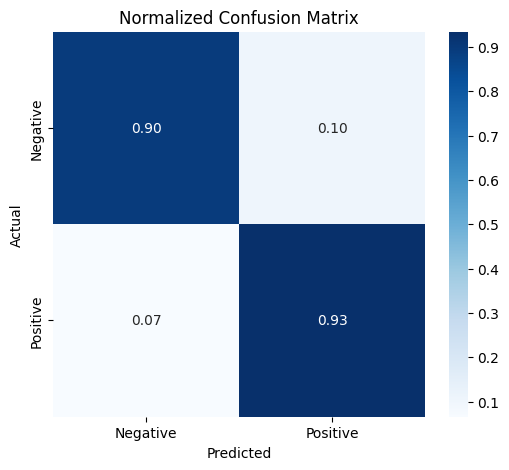

In [30]:
plot_confusion_matrix(test_true, test_preds, labels=["Negative", "Positive"])

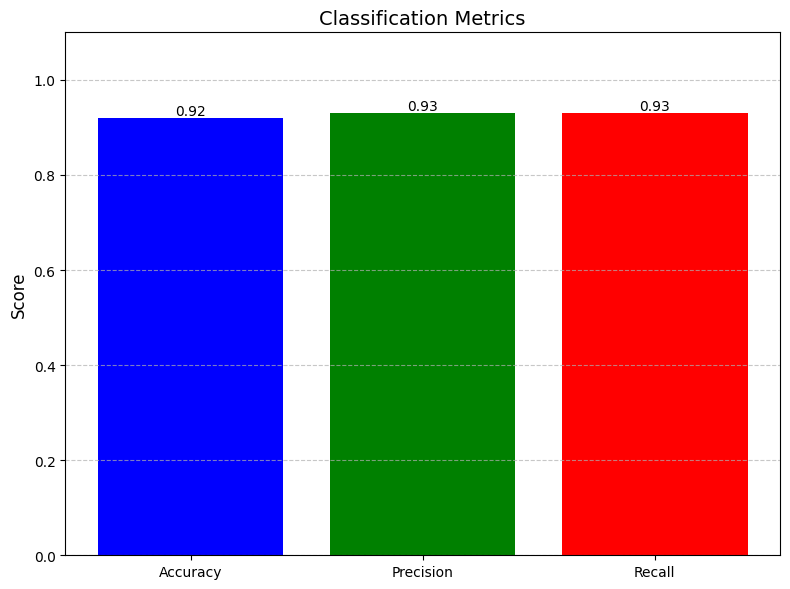

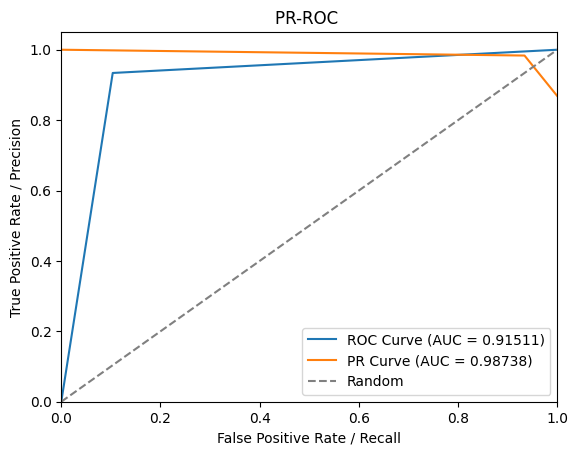

In [124]:
plot_auc(test_preds, test_true)

In [ ]:
def plot_training_curves(history, model_names, save_path='training_curves_comparison.png'):
    plt.figure(figsize=(16, 12))
    
    plt.subplot(2, 2, 1)
    plt.plot([1] + history['train_losses'], label=f'{model_names}')
        
    plt.xlabel('Epoch')
    plt.ylabel('loss ')
    plt.title('loss acc')
    plt.ylim(0.0, 1)
    plt.legend()
    plt.grid(linestyle='--', alpha=0.5)
    
    plt.subplot(2, 2, 2)
    plt.plot([0] + history['train_accuracies'], label=f'{model_names}')
    plt.xlabel('Epoch')
    plt.ylabel('acc (%)')
    plt.ylim(0.0, 100)
    plt.title('loss acc')
    plt.legend()
    plt.grid(linestyle='--', alpha=0.5)
    
    plt.tight_layout()
    plt.show()

def plot_training_curves2(history, model_names, save_path='training_curves_comparison.png'):
    plt.figure(figsize=(16, 12))
    # set start from 0
    history['train_losses'] = np.insert(history['train_losses'], 0, 0.75)
    history['val_losses'] = np.insert(history['val_losses'], 0, 0.75)
    history['train_accuracies'] = np.insert(history['train_accuracies'], 0, 0)
    history['val_accuracies'] = np.insert(history['val_accuracies'], 0, 0) 

    # plot train loss curve
    plt.subplot(2, 2, 1)
    plt.plot(history['train_losses'], label=f'{model_names}')
    plt.xlabel('Epoch')
    plt.ylabel('loss')
    plt.title('train loss')
    plt.ylim(0.0, 1)
    plt.legend()
    plt.grid(linestyle='--', alpha=0.5)
    
    # plot validation loss curve
    plt.subplot(2, 2, 2)
    plt.plot(history['val_losses'], label=f'{model_names}')
    plt.xlabel('Epoch')
    plt.ylabel('loss')
    plt.title('loss validation')
    plt.ylim(0.0, 1)
    plt.legend()
    plt.grid(linestyle='--', alpha=0.5)
    
    # plot train accuracy curve
    plt.subplot(2, 2, 3)
    plt.plot(history['train_accuracies'], label=f'{model_names}')
    plt.xlabel('Epoch')
    plt.ylabel('acc (%)')
    plt.title('acc train')
    plt.ylim(0.0, 100)
    plt.legend()
    plt.grid(linestyle='--', alpha=0.5)
    
    # plot validation accuracy curve
    plt.subplot(2, 2, 4)
    plt.plot(history['val_accuracies'], label=f'{model_names}')
    plt.xlabel('Epoch')
    plt.ylabel('acc (%)')
    plt.title('acc validation')
    plt.ylim(0.0, 100)

    plt.legend()
    plt.grid(linestyle='--', alpha=0.5)
    
    plt.tight_layout()
    plt.show()


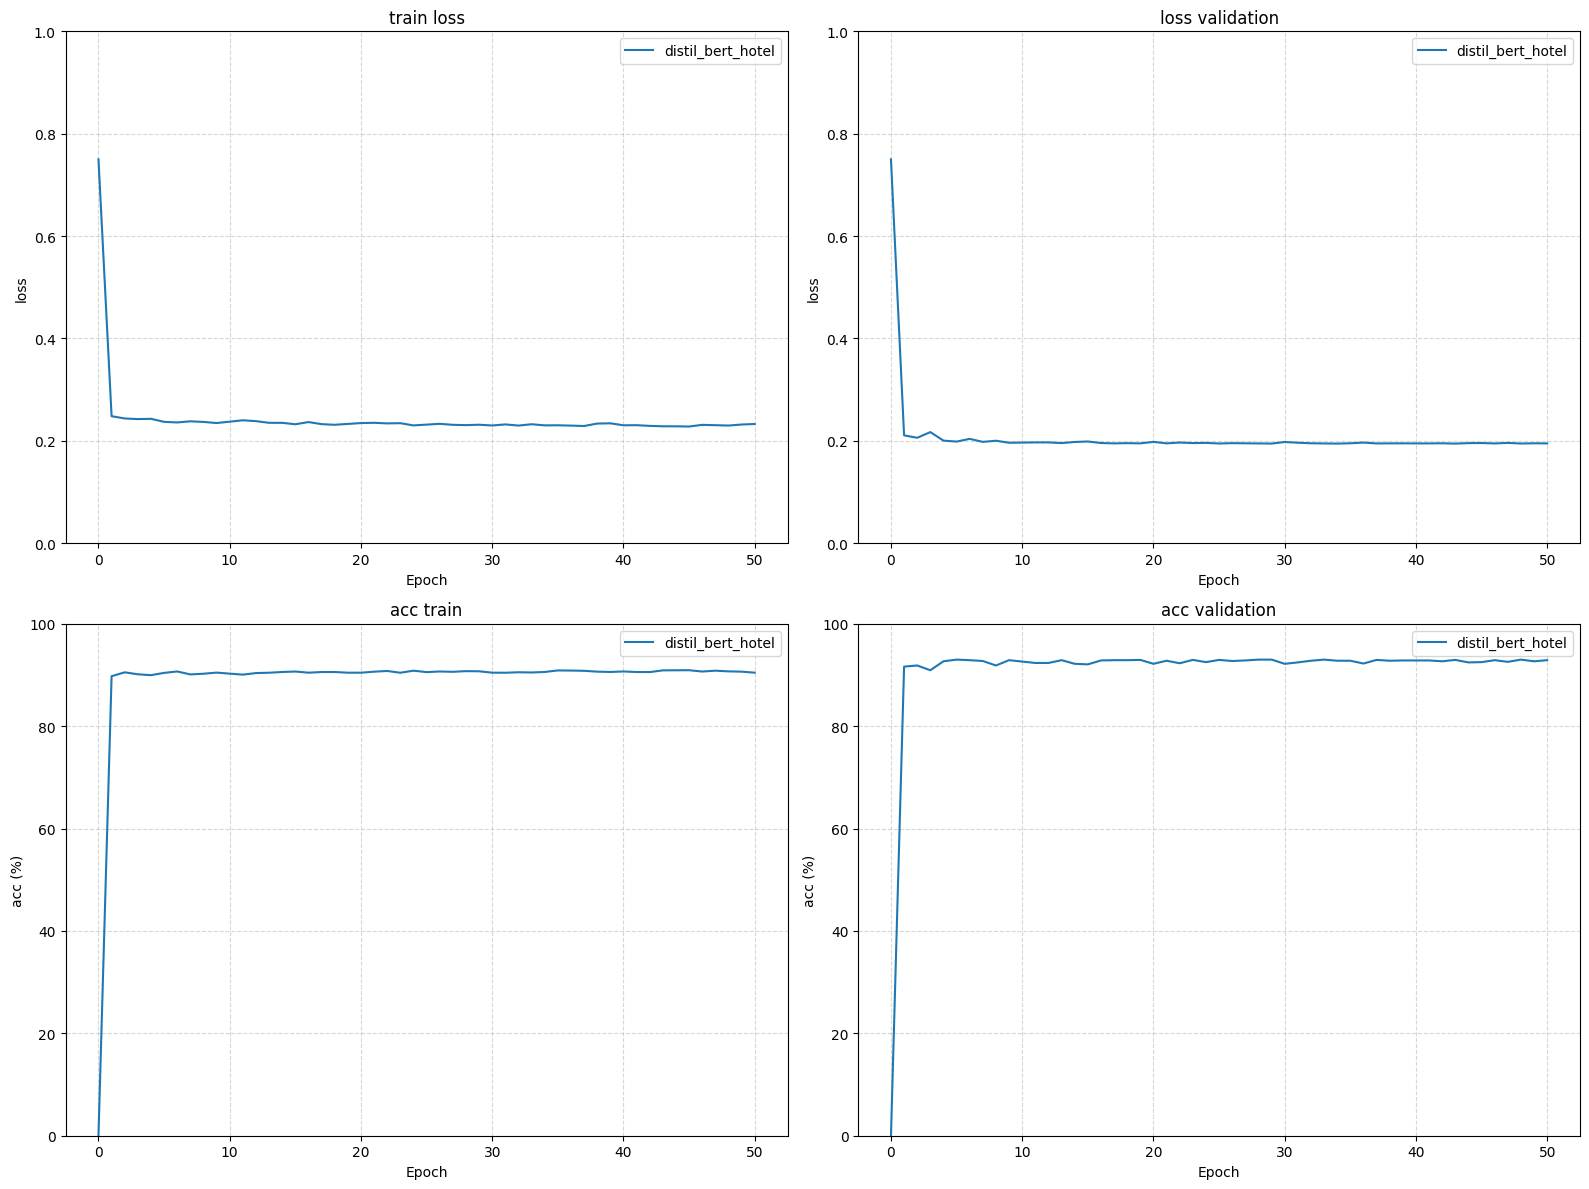

In [123]:
plot_training_curves2(history_hotel, 'distil_bert_hotel')

In [48]:
from types import SimpleNamespace
class TextCNN(nn.Module):
    def __init__(self, vocab_size, embed_dim, num_classes, kernel_sizes=[3], num_filters=8):
        super().__init__()
        self.embedding = nn.Embedding(vocab_size, embed_dim, padding_idx=0)
        self.convs = nn.ModuleList([
            nn.Conv2d(1, num_filters, (k, embed_dim)) for k in kernel_sizes
        ])
        self.dropout = nn.Dropout(0.7)
        self.fc = nn.Linear(num_filters * len(kernel_sizes), num_classes)

    def forward(self, input_ids, attention_mask=None,  labels=None):
        x = self.embedding(input_ids)  # [B, L, D]
        x = x.unsqueeze(1)             # [B, 1, L, D]
        x = [torch.relu(conv(x)).squeeze(3) for conv in self.convs]
        x = [torch.max(p, dim=2)[0] for p in x]
        x = torch.cat(x, dim=1)
        x = self.dropout(x)
        logits = self.fc(x)

        if labels is not None:
            loss = nn.CrossEntropyLoss()(logits, labels)
            return SimpleNamespace(loss=loss, logits=logits)
        else:
            return SimpleNamespace(logits=logits)
        
        # return self.fc(x)



In [32]:
class SentimentDataset2(Dataset):
    def __init__(self, texts, labels, tokenizer, max_len=64):
        self.texts = texts
        self.labels = labels
        self.tokenizer = tokenizer
        self.max_len = max_len

    def __len__(self):
        return len(self.texts)

    def __getitem__(self, idx):
        encoding = self.tokenizer.encode_plus(
            self.texts[idx],
            add_special_tokens=True,
            max_length=self.max_len,
            padding='max_length',
            truncation=True,
            return_tensors='pt'
        )
        return {
            'input_ids': encoding['input_ids'].squeeze(0),  # [L]
            'attention_mask': encoding['attention_mask'].squeeze(0),
            'labels': torch.tensor(self.labels[idx], dtype=torch.long)
        }

# TextCNN

In [ ]:
# ========== data processing ==========

data_collator = DataCollatorWithPadding(tokenizer_hotel)
train_dataset_cnn = SentimentDataset2(train_df_hotel["processed_text"].tolist(), 
                                      train_df_hotel['sentiment_encode'].tolist(), tokenizer_hotel)
test_dataset_cnn = SentimentDataset2(test_df_hotel["processed_text"].tolist(), 
                                     test_df_hotel['sentiment_encode'].tolist(), tokenizer_hotel)
train_loader_cnn = DataLoader(train_dataset_cnn, batch_size=16, shuffle=True, collate_fn=data_collator)
test_loader_cnn = DataLoader(test_dataset_cnn, batch_size=16, shuffle=False, collate_fn=data_collator)


vocab_size = tokenizer_hotel.vocab_size  #  embedding initialization
cnn_model = TextCNN(vocab_size, embed_dim=128, num_classes=2)


history_hotel_cnn = train(cnn_model, 
      train_loader_cnn, 
      test_loader_cnn, 
      save_path="distil_cnn_hotel.pth", 
      # fine_tuning = True,
      # target_names = ['negative', 'neutral', 'positive'],
      target_names = ['negative', 'positive'],
      num_epochs=50
     )

Evaluating: 100%|██████████| 110/110 [00:00<00:00, 117.20it/s]


Classification Report:
               precision    recall  f1-score   support

    negative       0.00      0.00      0.00       302
    positive       0.83      1.00      0.91      1450

    accuracy                           0.83      1752
   macro avg       0.41      0.50      0.45      1752
weighted avg       0.68      0.83      0.75      1752



Evaluating: 100%|██████████| 110/110 [00:00<00:00, 119.60it/s]


Classification Report:
               precision    recall  f1-score   support

    negative       1.00      0.01      0.02       302
    positive       0.83      1.00      0.91      1450

    accuracy                           0.83      1752
   macro avg       0.91      0.50      0.46      1752
weighted avg       0.86      0.83      0.75      1752



Evaluating: 100%|██████████| 110/110 [00:00<00:00, 119.90it/s]


Classification Report:
               precision    recall  f1-score   support

    negative       0.97      0.12      0.22       302
    positive       0.85      1.00      0.92      1450

    accuracy                           0.85      1752
   macro avg       0.91      0.56      0.57      1752
weighted avg       0.87      0.85      0.80      1752



Evaluating: 100%|██████████| 110/110 [00:00<00:00, 118.78it/s]


Classification Report:
               precision    recall  f1-score   support

    negative       0.95      0.23      0.37       302
    positive       0.86      1.00      0.92      1450

    accuracy                           0.86      1752
   macro avg       0.90      0.61      0.65      1752
weighted avg       0.88      0.86      0.83      1752



Evaluating: 100%|██████████| 110/110 [00:00<00:00, 118.46it/s]


Classification Report:
               precision    recall  f1-score   support

    negative       0.95      0.33      0.49       302
    positive       0.88      1.00      0.93      1450

    accuracy                           0.88      1752
   macro avg       0.91      0.66      0.71      1752
weighted avg       0.89      0.88      0.86      1752



Evaluating: 100%|██████████| 110/110 [00:00<00:00, 116.41it/s]


Classification Report:
               precision    recall  f1-score   support

    negative       0.94      0.39      0.56       302
    positive       0.89      1.00      0.94      1450

    accuracy                           0.89      1752
   macro avg       0.92      0.69      0.75      1752
weighted avg       0.90      0.89      0.87      1752



Evaluating: 100%|██████████| 110/110 [00:00<00:00, 119.63it/s]


Classification Report:
               precision    recall  f1-score   support

    negative       0.90      0.46      0.61       302
    positive       0.90      0.99      0.94      1450

    accuracy                           0.90      1752
   macro avg       0.90      0.72      0.78      1752
weighted avg       0.90      0.90      0.88      1752



Evaluating: 100%|██████████| 110/110 [00:00<00:00, 118.55it/s]


Classification Report:
               precision    recall  f1-score   support

    negative       0.91      0.56      0.69       302
    positive       0.92      0.99      0.95      1450

    accuracy                           0.91      1752
   macro avg       0.91      0.77      0.82      1752
weighted avg       0.91      0.91      0.91      1752



Evaluating: 100%|██████████| 110/110 [00:00<00:00, 117.91it/s]


Classification Report:
               precision    recall  f1-score   support

    negative       0.90      0.50      0.64       302
    positive       0.90      0.99      0.94      1450

    accuracy                           0.90      1752
   macro avg       0.90      0.74      0.79      1752
weighted avg       0.90      0.90      0.89      1752



Evaluating: 100%|██████████| 110/110 [00:00<00:00, 119.85it/s]


Classification Report:
               precision    recall  f1-score   support

    negative       0.90      0.56      0.69       302
    positive       0.91      0.99      0.95      1450

    accuracy                           0.91      1752
   macro avg       0.91      0.77      0.82      1752
weighted avg       0.91      0.91      0.90      1752



Evaluating: 100%|██████████| 110/110 [00:00<00:00, 119.86it/s]


Classification Report:
               precision    recall  f1-score   support

    negative       0.93      0.50      0.65       302
    positive       0.91      0.99      0.95      1450

    accuracy                           0.91      1752
   macro avg       0.92      0.75      0.80      1752
weighted avg       0.91      0.91      0.90      1752



Evaluating: 100%|██████████| 110/110 [00:00<00:00, 122.61it/s]


Classification Report:
               precision    recall  f1-score   support

    negative       0.88      0.58      0.70       302
    positive       0.92      0.98      0.95      1450

    accuracy                           0.91      1752
   macro avg       0.90      0.78      0.83      1752
weighted avg       0.91      0.91      0.91      1752



Evaluating: 100%|██████████| 110/110 [00:00<00:00, 121.21it/s]


Classification Report:
               precision    recall  f1-score   support

    negative       0.90      0.59      0.71       302
    positive       0.92      0.99      0.95      1450

    accuracy                           0.92      1752
   macro avg       0.91      0.79      0.83      1752
weighted avg       0.92      0.92      0.91      1752



Evaluating: 100%|██████████| 110/110 [00:00<00:00, 118.21it/s]


Classification Report:
               precision    recall  f1-score   support

    negative       0.87      0.62      0.72       302
    positive       0.93      0.98      0.95      1450

    accuracy                           0.92      1752
   macro avg       0.90      0.80      0.84      1752
weighted avg       0.92      0.92      0.91      1752



Evaluating: 100%|██████████| 110/110 [00:00<00:00, 119.08it/s]


Classification Report:
               precision    recall  f1-score   support

    negative       0.85      0.60      0.71       302
    positive       0.92      0.98      0.95      1450

    accuracy                           0.91      1752
   macro avg       0.89      0.79      0.83      1752
weighted avg       0.91      0.91      0.91      1752



Evaluating: 100%|██████████| 110/110 [00:00<00:00, 119.47it/s]


Classification Report:
               precision    recall  f1-score   support

    negative       0.86      0.58      0.70       302
    positive       0.92      0.98      0.95      1450

    accuracy                           0.91      1752
   macro avg       0.89      0.78      0.82      1752
weighted avg       0.91      0.91      0.91      1752



Evaluating: 100%|██████████| 110/110 [00:00<00:00, 122.41it/s]


Classification Report:
               precision    recall  f1-score   support

    negative       0.87      0.57      0.69       302
    positive       0.92      0.98      0.95      1450

    accuracy                           0.91      1752
   macro avg       0.90      0.78      0.82      1752
weighted avg       0.91      0.91      0.90      1752



Evaluating: 100%|██████████| 110/110 [00:00<00:00, 123.33it/s]


Classification Report:
               precision    recall  f1-score   support

    negative       0.90      0.54      0.67       302
    positive       0.91      0.99      0.95      1450

    accuracy                           0.91      1752
   macro avg       0.90      0.76      0.81      1752
weighted avg       0.91      0.91      0.90      1752



Evaluating: 100%|██████████| 110/110 [00:00<00:00, 120.71it/s]


Classification Report:
               precision    recall  f1-score   support

    negative       0.85      0.63      0.72       302
    positive       0.93      0.98      0.95      1450

    accuracy                           0.92      1752
   macro avg       0.89      0.80      0.84      1752
weighted avg       0.91      0.92      0.91      1752



Evaluating: 100%|██████████| 110/110 [00:00<00:00, 120.57it/s]


Classification Report:
               precision    recall  f1-score   support

    negative       0.83      0.61      0.70       302
    positive       0.92      0.97      0.95      1450

    accuracy                           0.91      1752
   macro avg       0.87      0.79      0.83      1752
weighted avg       0.91      0.91      0.91      1752



Evaluating: 100%|██████████| 110/110 [00:00<00:00, 118.46it/s]


Classification Report:
               precision    recall  f1-score   support

    negative       0.84      0.61      0.71       302
    positive       0.92      0.98      0.95      1450

    accuracy                           0.91      1752
   macro avg       0.88      0.79      0.83      1752
weighted avg       0.91      0.91      0.91      1752



Evaluating: 100%|██████████| 110/110 [00:00<00:00, 123.46it/s]


Classification Report:
               precision    recall  f1-score   support

    negative       0.85      0.57      0.69       302
    positive       0.92      0.98      0.95      1450

    accuracy                           0.91      1752
   macro avg       0.88      0.78      0.82      1752
weighted avg       0.91      0.91      0.90      1752



Evaluating: 100%|██████████| 110/110 [00:00<00:00, 125.49it/s]


Classification Report:
               precision    recall  f1-score   support

    negative       0.86      0.58      0.69       302
    positive       0.92      0.98      0.95      1450

    accuracy                           0.91      1752
   macro avg       0.89      0.78      0.82      1752
weighted avg       0.91      0.91      0.90      1752



Evaluating: 100%|██████████| 110/110 [00:00<00:00, 120.10it/s]


Classification Report:
               precision    recall  f1-score   support

    negative       0.88      0.60      0.71       302
    positive       0.92      0.98      0.95      1450

    accuracy                           0.92      1752
   macro avg       0.90      0.79      0.83      1752
weighted avg       0.92      0.92      0.91      1752



Evaluating: 100%|██████████| 110/110 [00:00<00:00, 119.54it/s]


Classification Report:
               precision    recall  f1-score   support

    negative       0.85      0.61      0.71       302
    positive       0.92      0.98      0.95      1450

    accuracy                           0.91      1752
   macro avg       0.89      0.79      0.83      1752
weighted avg       0.91      0.91      0.91      1752



Evaluating: 100%|██████████| 110/110 [00:00<00:00, 116.31it/s]


Classification Report:
               precision    recall  f1-score   support

    negative       0.84      0.58      0.69       302
    positive       0.92      0.98      0.95      1450

    accuracy                           0.91      1752
   macro avg       0.88      0.78      0.82      1752
weighted avg       0.91      0.91      0.90      1752



Evaluating: 100%|██████████| 110/110 [00:00<00:00, 120.35it/s]


Classification Report:
               precision    recall  f1-score   support

    negative       0.83      0.59      0.69       302
    positive       0.92      0.97      0.95      1450

    accuracy                           0.91      1752
   macro avg       0.87      0.78      0.82      1752
weighted avg       0.90      0.91      0.90      1752



Evaluating: 100%|██████████| 110/110 [00:00<00:00, 117.48it/s]


Classification Report:
               precision    recall  f1-score   support

    negative       0.84      0.62      0.71       302
    positive       0.92      0.98      0.95      1450

    accuracy                           0.91      1752
   macro avg       0.88      0.80      0.83      1752
weighted avg       0.91      0.91      0.91      1752



Evaluating: 100%|██████████| 110/110 [00:00<00:00, 117.93it/s]


Classification Report:
               precision    recall  f1-score   support

    negative       0.85      0.58      0.69       302
    positive       0.92      0.98      0.95      1450

    accuracy                           0.91      1752
   macro avg       0.88      0.78      0.82      1752
weighted avg       0.91      0.91      0.90      1752



Evaluating: 100%|██████████| 110/110 [00:00<00:00, 119.01it/s]


Classification Report:
               precision    recall  f1-score   support

    negative       0.86      0.56      0.68       302
    positive       0.91      0.98      0.95      1450

    accuracy                           0.91      1752
   macro avg       0.89      0.77      0.81      1752
weighted avg       0.90      0.91      0.90      1752



Evaluating: 100%|██████████| 110/110 [00:00<00:00, 119.68it/s]


Classification Report:
               precision    recall  f1-score   support

    negative       0.86      0.57      0.68       302
    positive       0.92      0.98      0.95      1450

    accuracy                           0.91      1752
   macro avg       0.89      0.77      0.82      1752
weighted avg       0.91      0.91      0.90      1752



Evaluating: 100%|██████████| 110/110 [00:00<00:00, 122.11it/s]


Classification Report:
               precision    recall  f1-score   support

    negative       0.86      0.57      0.69       302
    positive       0.92      0.98      0.95      1450

    accuracy                           0.91      1752
   macro avg       0.89      0.78      0.82      1752
weighted avg       0.91      0.91      0.90      1752



Evaluating: 100%|██████████| 110/110 [00:00<00:00, 119.81it/s]


Classification Report:
               precision    recall  f1-score   support

    negative       0.88      0.57      0.69       302
    positive       0.92      0.98      0.95      1450

    accuracy                           0.91      1752
   macro avg       0.90      0.77      0.82      1752
weighted avg       0.91      0.91      0.90      1752



Evaluating: 100%|██████████| 110/110 [00:00<00:00, 119.77it/s]


Classification Report:
               precision    recall  f1-score   support

    negative       0.85      0.59      0.69       302
    positive       0.92      0.98      0.95      1450

    accuracy                           0.91      1752
   macro avg       0.88      0.78      0.82      1752
weighted avg       0.91      0.91      0.90      1752



Evaluating: 100%|██████████| 110/110 [00:00<00:00, 126.69it/s]


Classification Report:
               precision    recall  f1-score   support

    negative       0.86      0.61      0.71       302
    positive       0.92      0.98      0.95      1450

    accuracy                           0.92      1752
   macro avg       0.89      0.80      0.83      1752
weighted avg       0.91      0.92      0.91      1752



Evaluating: 100%|██████████| 110/110 [00:00<00:00, 132.16it/s]


Classification Report:
               precision    recall  f1-score   support

    negative       0.85      0.59      0.70       302
    positive       0.92      0.98      0.95      1450

    accuracy                           0.91      1752
   macro avg       0.88      0.79      0.82      1752
weighted avg       0.91      0.91      0.91      1752



Evaluating: 100%|██████████| 110/110 [00:00<00:00, 127.62it/s]


Classification Report:
               precision    recall  f1-score   support

    negative       0.85      0.59      0.69       302
    positive       0.92      0.98      0.95      1450

    accuracy                           0.91      1752
   macro avg       0.89      0.78      0.82      1752
weighted avg       0.91      0.91      0.90      1752



Evaluating: 100%|██████████| 110/110 [00:00<00:00, 124.36it/s]


Classification Report:
               precision    recall  f1-score   support

    negative       0.83      0.58      0.68       302
    positive       0.92      0.97      0.95      1450

    accuracy                           0.91      1752
   macro avg       0.87      0.78      0.81      1752
weighted avg       0.90      0.91      0.90      1752



Evaluating: 100%|██████████| 110/110 [00:00<00:00, 118.78it/s]


Classification Report:
               precision    recall  f1-score   support

    negative       0.84      0.57      0.68       302
    positive       0.92      0.98      0.95      1450

    accuracy                           0.91      1752
   macro avg       0.88      0.77      0.81      1752
weighted avg       0.90      0.91      0.90      1752



Evaluating: 100%|██████████| 110/110 [00:00<00:00, 117.92it/s]


Classification Report:
               precision    recall  f1-score   support

    negative       0.85      0.57      0.69       302
    positive       0.92      0.98      0.95      1450

    accuracy                           0.91      1752
   macro avg       0.88      0.78      0.82      1752
weighted avg       0.91      0.91      0.90      1752



Evaluating: 100%|██████████| 110/110 [00:00<00:00, 120.69it/s]


Classification Report:
               precision    recall  f1-score   support

    negative       0.86      0.60      0.70       302
    positive       0.92      0.98      0.95      1450

    accuracy                           0.91      1752
   macro avg       0.89      0.79      0.83      1752
weighted avg       0.91      0.91      0.91      1752



Evaluating: 100%|██████████| 110/110 [00:00<00:00, 119.22it/s]


Classification Report:
               precision    recall  f1-score   support

    negative       0.83      0.58      0.68       302
    positive       0.92      0.98      0.95      1450

    accuracy                           0.91      1752
   macro avg       0.87      0.78      0.81      1752
weighted avg       0.90      0.91      0.90      1752



Evaluating: 100%|██████████| 110/110 [00:00<00:00, 117.19it/s]


Classification Report:
               precision    recall  f1-score   support

    negative       0.84      0.57      0.68       302
    positive       0.92      0.98      0.95      1450

    accuracy                           0.91      1752
   macro avg       0.88      0.77      0.81      1752
weighted avg       0.90      0.91      0.90      1752



Evaluating: 100%|██████████| 110/110 [00:00<00:00, 122.43it/s]


Classification Report:
               precision    recall  f1-score   support

    negative       0.85      0.58      0.69       302
    positive       0.92      0.98      0.95      1450

    accuracy                           0.91      1752
   macro avg       0.88      0.78      0.82      1752
weighted avg       0.91      0.91      0.90      1752



Evaluating: 100%|██████████| 110/110 [00:00<00:00, 117.62it/s]


Classification Report:
               precision    recall  f1-score   support

    negative       0.84      0.56      0.67       302
    positive       0.91      0.98      0.94      1450

    accuracy                           0.90      1752
   macro avg       0.87      0.77      0.81      1752
weighted avg       0.90      0.90      0.90      1752



Evaluating: 100%|██████████| 110/110 [00:00<00:00, 120.30it/s]


Classification Report:
               precision    recall  f1-score   support

    negative       0.86      0.56      0.68       302
    positive       0.91      0.98      0.95      1450

    accuracy                           0.91      1752
   macro avg       0.89      0.77      0.81      1752
weighted avg       0.90      0.91      0.90      1752



Evaluating: 100%|██████████| 110/110 [00:00<00:00, 116.84it/s]


Classification Report:
               precision    recall  f1-score   support

    negative       0.85      0.57      0.68       302
    positive       0.92      0.98      0.95      1450

    accuracy                           0.91      1752
   macro avg       0.88      0.77      0.81      1752
weighted avg       0.90      0.91      0.90      1752



Evaluating: 100%|██████████| 110/110 [00:00<00:00, 121.71it/s]


Classification Report:
               precision    recall  f1-score   support

    negative       0.85      0.54      0.66       302
    positive       0.91      0.98      0.94      1450

    accuracy                           0.90      1752
   macro avg       0.88      0.76      0.80      1752
weighted avg       0.90      0.90      0.90      1752



Evaluating: 100%|██████████| 110/110 [00:00<00:00, 123.25it/s]


Classification Report:
               precision    recall  f1-score   support

    negative       0.85      0.56      0.67       302
    positive       0.91      0.98      0.95      1450

    accuracy                           0.91      1752
   macro avg       0.88      0.77      0.81      1752
weighted avg       0.90      0.91      0.90      1752



Evaluating: 100%|██████████| 110/110 [00:00<00:00, 121.48it/s]


Classification Report:
               precision    recall  f1-score   support

    negative       0.84      0.56      0.67       302
    positive       0.91      0.98      0.95      1450

    accuracy                           0.91      1752
   macro avg       0.88      0.77      0.81      1752
weighted avg       0.90      0.91      0.90      1752


Saving model...distil_cnn_hotel.pth


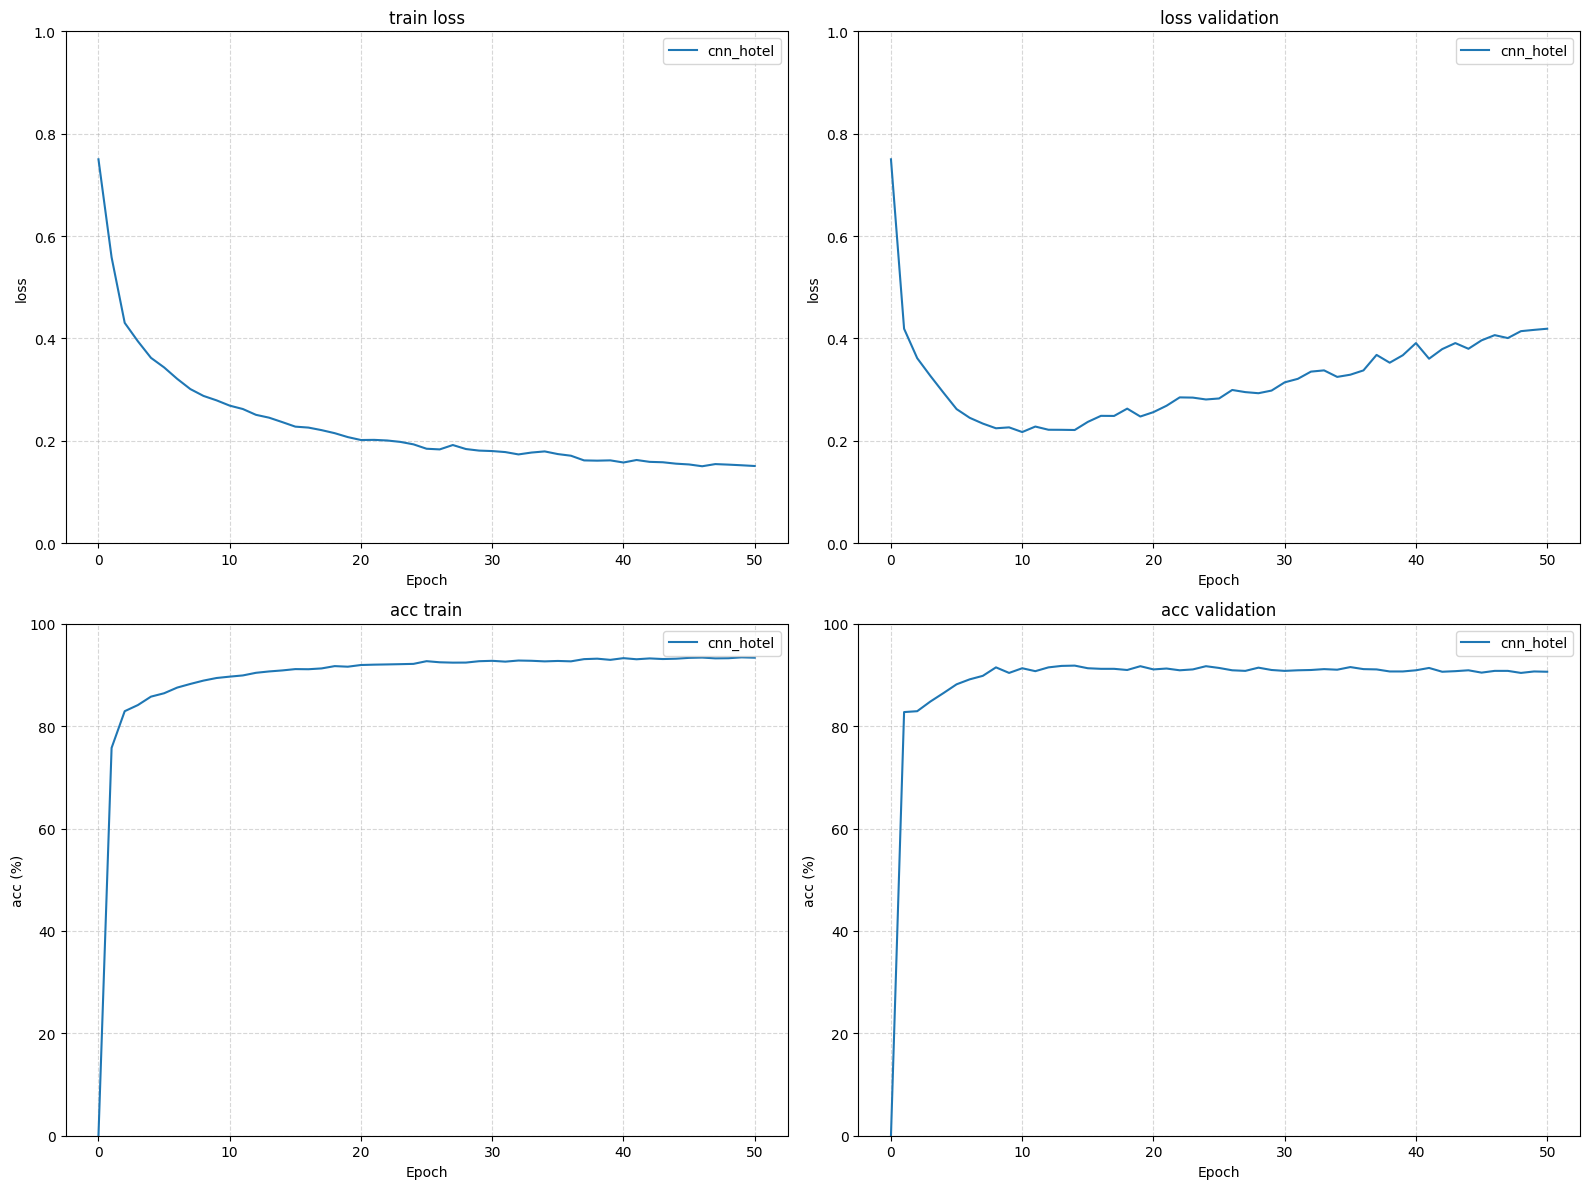

In [50]:
plot_training_curves2(history_hotel_cnn, 'cnn_hotel')

In [80]:
cnn_model

TextCNN(
  (embedding): Embedding(30522, 128, padding_idx=0)
  (convs): ModuleList(
    (0): Conv2d(1, 8, kernel_size=(3, 128), stride=(1, 1))
  )
  (dropout): Dropout(p=0.7, inplace=False)
  (fc): Linear(in_features=8, out_features=2, bias=True)
)

In [76]:
# checkpoint = torch.load("distil_cnn_hotel.pth")
# model_hotel = DistilBertForSequenceClassification.from_pretrained('distilbert-base-uncased', num_labels=2)
# model_hotel.load_state_dict(checkpoint["model_state_dict"])

device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
cnn_model.to(device)
# all_preds, all_labels, avg_loss, acc*100.
test_true, test_preds, _,_ = evaluate2(cnn_model, device, test_loader_cnn)
accuracy = accuracy_score(test_true, test_preds)
print(f"Test Accuracy: {accuracy * 100:.2f}%\n")

Evaluating: 100%|██████████| 110/110 [00:01<00:00, 105.21it/s]

Test Accuracy: 90.64%



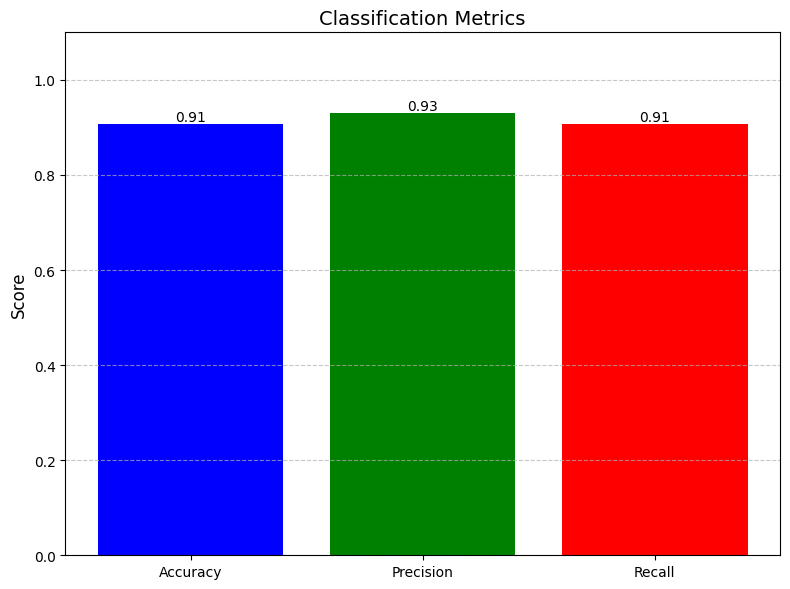

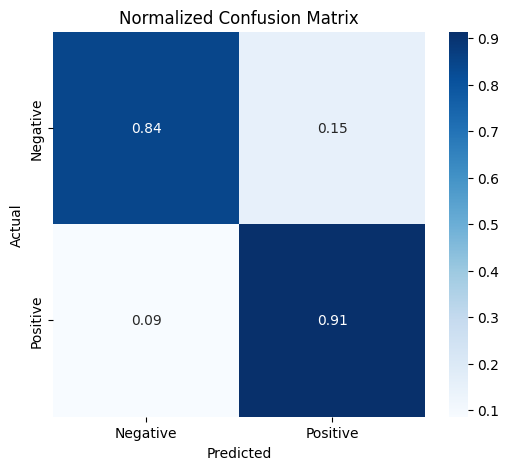

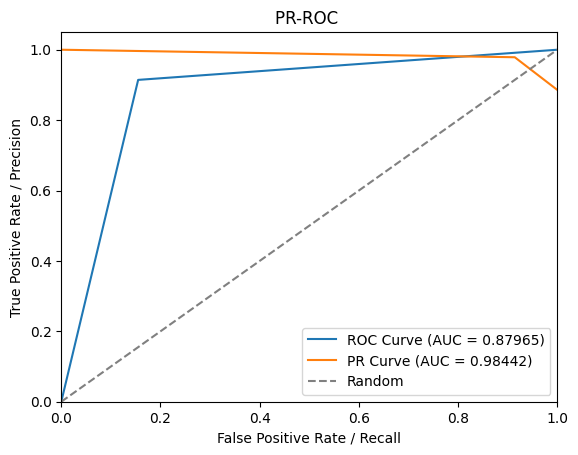

In [77]:
from sklearn.metrics import accuracy_score, precision_score, recall_score, f1_score, classification_report

acc = accuracy_score(test_true, test_preds)
precision = precision_score(test_true, test_preds, average='weighted')  # 或 'micro', 'weighted'
recall = recall_score(test_true, test_preds, average='weighted')
f1 = f1_score(test_true, test_preds, average='weighted')
draw_bar(acc, precision, recall)
plot_confusion_matrix(test_true, test_preds, labels=["Negative", "Positive"])
plot_auc(test_preds, test_true)

# LSTM

In [59]:
class Attention(nn.Module):
    def __init__(self, hidden_dim):
        super().__init__()
        self.attn = nn.Linear(hidden_dim * 2, 1)

    def forward(self, lstm_output):
        weights = torch.softmax(self.attn(lstm_output), dim=1)
        context = torch.sum(weights * lstm_output, dim=1)
        return context

class BiLSTM_Attn(nn.Module):
    def __init__(self, vocab_size, embed_dim, hidden_dim, num_classes):
        super().__init__()
        self.embedding = nn.Embedding(vocab_size, embed_dim, padding_idx=0)
        self.lstm = nn.LSTM(embed_dim, hidden_dim, batch_first=True, bidirectional=True)
        # self.attn = Attention(hidden_dim)
        self.attn = None
        self.fc = nn.Linear(hidden_dim * 2, num_classes)
        self.dropout = nn.Dropout(0.7)

    def forward(self, input_ids, attention_mask=None, labels=None):
        x = self.embedding(input_ids)
        lstm_out, _ = self.lstm(x)

        if self.attn:
            x = self.attn(lstm_out)
        else:
            x = lstm_out[:, -1, :]

        x = self.dropout(x)
        logits = self.fc(x)

        if labels is not None:
            loss = nn.CrossEntropyLoss()(logits, labels)
            return SimpleNamespace(loss=loss, logits=logits)
        else:
            return SimpleNamespace(logits=logits)

In [60]:


model_lstm = BiLSTM_Attn(vocab_size, embed_dim=32, hidden_dim=32, num_classes=2)

history_hotel_lstm = train(model_lstm, 
      train_loader_cnn, 
      test_loader_cnn, 
      save_path="distil_lstm_hotel.pth", 
      # fine_tuning = True,
      # target_names = ['negative', 'neutral', 'positive'],
      target_names = ['negative', 'positive'],
      num_epochs=50
     )

训练中 1:   0%|          | 0/986 [00:00<?, ?it/s]

Evaluating: 100%|██████████| 110/110 [00:01<00:00, 103.39it/s]


Classification Report:
               precision    recall  f1-score   support

    negative       0.73      0.39      0.51       302
    positive       0.88      0.97      0.92      1450

    accuracy                           0.87      1752
   macro avg       0.81      0.68      0.72      1752
weighted avg       0.86      0.87      0.85      1752



Evaluating: 100%|██████████| 110/110 [00:01<00:00, 102.98it/s]


Classification Report:
               precision    recall  f1-score   support

    negative       0.78      0.45      0.57       302
    positive       0.89      0.97      0.93      1450

    accuracy                           0.88      1752
   macro avg       0.84      0.71      0.75      1752
weighted avg       0.87      0.88      0.87      1752



Evaluating: 100%|██████████| 110/110 [00:01<00:00, 103.42it/s]


Classification Report:
               precision    recall  f1-score   support

    negative       0.66      0.74      0.70       302
    positive       0.94      0.92      0.93      1450

    accuracy                           0.89      1752
   macro avg       0.80      0.83      0.82      1752
weighted avg       0.90      0.89      0.89      1752



Evaluating: 100%|██████████| 110/110 [00:01<00:00, 103.21it/s]


Classification Report:
               precision    recall  f1-score   support

    negative       0.60      0.49      0.54       302
    positive       0.90      0.93      0.91      1450

    accuracy                           0.86      1752
   macro avg       0.75      0.71      0.73      1752
weighted avg       0.85      0.86      0.85      1752



Evaluating: 100%|██████████| 110/110 [00:01<00:00, 102.16it/s]


Classification Report:
               precision    recall  f1-score   support

    negative       0.78      0.69      0.73       302
    positive       0.94      0.96      0.95      1450

    accuracy                           0.91      1752
   macro avg       0.86      0.82      0.84      1752
weighted avg       0.91      0.91      0.91      1752



Evaluating: 100%|██████████| 110/110 [00:01<00:00, 104.79it/s]


Classification Report:
               precision    recall  f1-score   support

    negative       0.76      0.77      0.77       302
    positive       0.95      0.95      0.95      1450

    accuracy                           0.92      1752
   macro avg       0.86      0.86      0.86      1752
weighted avg       0.92      0.92      0.92      1752



Evaluating: 100%|██████████| 110/110 [00:01<00:00, 102.71it/s]


Classification Report:
               precision    recall  f1-score   support

    negative       0.83      0.76      0.80       302
    positive       0.95      0.97      0.96      1450

    accuracy                           0.93      1752
   macro avg       0.89      0.86      0.88      1752
weighted avg       0.93      0.93      0.93      1752



Evaluating: 100%|██████████| 110/110 [00:01<00:00, 102.37it/s]


Classification Report:
               precision    recall  f1-score   support

    negative       0.87      0.70      0.78       302
    positive       0.94      0.98      0.96      1450

    accuracy                           0.93      1752
   macro avg       0.91      0.84      0.87      1752
weighted avg       0.93      0.93      0.93      1752



Evaluating: 100%|██████████| 110/110 [00:01<00:00, 103.90it/s]


Classification Report:
               precision    recall  f1-score   support

    negative       0.86      0.72      0.78       302
    positive       0.94      0.98      0.96      1450

    accuracy                           0.93      1752
   macro avg       0.90      0.85      0.87      1752
weighted avg       0.93      0.93      0.93      1752



Evaluating: 100%|██████████| 110/110 [00:01<00:00, 102.38it/s]


Classification Report:
               precision    recall  f1-score   support

    negative       0.86      0.75      0.80       302
    positive       0.95      0.97      0.96      1450

    accuracy                           0.93      1752
   macro avg       0.90      0.86      0.88      1752
weighted avg       0.93      0.93      0.93      1752



Evaluating: 100%|██████████| 110/110 [00:01<00:00, 104.52it/s]


Classification Report:
               precision    recall  f1-score   support

    negative       0.80      0.80      0.80       302
    positive       0.96      0.96      0.96      1450

    accuracy                           0.93      1752
   macro avg       0.88      0.88      0.88      1752
weighted avg       0.93      0.93      0.93      1752



Evaluating: 100%|██████████| 110/110 [00:01<00:00, 106.86it/s]


Classification Report:
               precision    recall  f1-score   support

    negative       0.83      0.77      0.80       302
    positive       0.95      0.97      0.96      1450

    accuracy                           0.93      1752
   macro avg       0.89      0.87      0.88      1752
weighted avg       0.93      0.93      0.93      1752



Evaluating: 100%|██████████| 110/110 [00:01<00:00, 104.09it/s]


Classification Report:
               precision    recall  f1-score   support

    negative       0.89      0.68      0.77       302
    positive       0.94      0.98      0.96      1450

    accuracy                           0.93      1752
   macro avg       0.91      0.83      0.87      1752
weighted avg       0.93      0.93      0.93      1752



Evaluating: 100%|██████████| 110/110 [00:01<00:00, 104.15it/s]


Classification Report:
               precision    recall  f1-score   support

    negative       0.75      0.78      0.77       302
    positive       0.95      0.95      0.95      1450

    accuracy                           0.92      1752
   macro avg       0.85      0.87      0.86      1752
weighted avg       0.92      0.92      0.92      1752



Evaluating: 100%|██████████| 110/110 [00:01<00:00, 102.44it/s]


Classification Report:
               precision    recall  f1-score   support

    negative       0.86      0.75      0.80       302
    positive       0.95      0.98      0.96      1450

    accuracy                           0.94      1752
   macro avg       0.91      0.86      0.88      1752
weighted avg       0.93      0.94      0.93      1752



Evaluating: 100%|██████████| 110/110 [00:01<00:00, 102.54it/s]


Classification Report:
               precision    recall  f1-score   support

    negative       0.83      0.78      0.81       302
    positive       0.96      0.97      0.96      1450

    accuracy                           0.93      1752
   macro avg       0.89      0.88      0.88      1752
weighted avg       0.93      0.93      0.93      1752



Evaluating: 100%|██████████| 110/110 [00:01<00:00, 102.11it/s]


Classification Report:
               precision    recall  f1-score   support

    negative       0.84      0.74      0.78       302
    positive       0.95      0.97      0.96      1450

    accuracy                           0.93      1752
   macro avg       0.89      0.85      0.87      1752
weighted avg       0.93      0.93      0.93      1752



Evaluating: 100%|██████████| 110/110 [00:01<00:00, 103.71it/s]


Classification Report:
               precision    recall  f1-score   support

    negative       0.78      0.78      0.78       302
    positive       0.95      0.96      0.95      1450

    accuracy                           0.93      1752
   macro avg       0.87      0.87      0.87      1752
weighted avg       0.93      0.93      0.93      1752



Evaluating: 100%|██████████| 110/110 [00:01<00:00, 103.27it/s]


Classification Report:
               precision    recall  f1-score   support

    negative       0.83      0.77      0.80       302
    positive       0.95      0.97      0.96      1450

    accuracy                           0.93      1752
   macro avg       0.89      0.87      0.88      1752
weighted avg       0.93      0.93      0.93      1752



Evaluating: 100%|██████████| 110/110 [00:01<00:00, 101.29it/s]


Classification Report:
               precision    recall  f1-score   support

    negative       0.83      0.75      0.79       302
    positive       0.95      0.97      0.96      1450

    accuracy                           0.93      1752
   macro avg       0.89      0.86      0.87      1752
weighted avg       0.93      0.93      0.93      1752



Evaluating: 100%|██████████| 110/110 [00:01<00:00, 103.83it/s]


Classification Report:
               precision    recall  f1-score   support

    negative       0.82      0.75      0.79       302
    positive       0.95      0.97      0.96      1450

    accuracy                           0.93      1752
   macro avg       0.89      0.86      0.87      1752
weighted avg       0.93      0.93      0.93      1752



Evaluating: 100%|██████████| 110/110 [00:01<00:00, 105.80it/s]


Classification Report:
               precision    recall  f1-score   support

    negative       0.88      0.70      0.78       302
    positive       0.94      0.98      0.96      1450

    accuracy                           0.93      1752
   macro avg       0.91      0.84      0.87      1752
weighted avg       0.93      0.93      0.93      1752



Evaluating: 100%|██████████| 110/110 [00:01<00:00, 105.03it/s]


Classification Report:
               precision    recall  f1-score   support

    negative       0.82      0.77      0.80       302
    positive       0.95      0.96      0.96      1450

    accuracy                           0.93      1752
   macro avg       0.89      0.87      0.88      1752
weighted avg       0.93      0.93      0.93      1752



Evaluating: 100%|██████████| 110/110 [00:01<00:00, 103.79it/s]


Classification Report:
               precision    recall  f1-score   support

    negative       0.83      0.74      0.78       302
    positive       0.95      0.97      0.96      1450

    accuracy                           0.93      1752
   macro avg       0.89      0.85      0.87      1752
weighted avg       0.93      0.93      0.93      1752



Evaluating: 100%|██████████| 110/110 [00:01<00:00, 104.26it/s]


Classification Report:
               precision    recall  f1-score   support

    negative       0.85      0.74      0.79       302
    positive       0.95      0.97      0.96      1450

    accuracy                           0.93      1752
   macro avg       0.90      0.86      0.88      1752
weighted avg       0.93      0.93      0.93      1752



Evaluating: 100%|██████████| 110/110 [00:01<00:00, 105.48it/s]


Classification Report:
               precision    recall  f1-score   support

    negative       0.84      0.68      0.75       302
    positive       0.94      0.97      0.95      1450

    accuracy                           0.92      1752
   macro avg       0.89      0.83      0.85      1752
weighted avg       0.92      0.92      0.92      1752



Evaluating: 100%|██████████| 110/110 [00:01<00:00, 105.60it/s]


Classification Report:
               precision    recall  f1-score   support

    negative       0.79      0.77      0.78       302
    positive       0.95      0.96      0.95      1450

    accuracy                           0.92      1752
   macro avg       0.87      0.86      0.87      1752
weighted avg       0.92      0.92      0.92      1752



Evaluating: 100%|██████████| 110/110 [00:00<00:00, 110.93it/s]


Classification Report:
               precision    recall  f1-score   support

    negative       0.85      0.70      0.77       302
    positive       0.94      0.97      0.96      1450

    accuracy                           0.93      1752
   macro avg       0.89      0.84      0.86      1752
weighted avg       0.92      0.93      0.92      1752



Evaluating: 100%|██████████| 110/110 [00:01<00:00, 104.23it/s]


Classification Report:
               precision    recall  f1-score   support

    negative       0.82      0.73      0.78       302
    positive       0.95      0.97      0.96      1450

    accuracy                           0.93      1752
   macro avg       0.89      0.85      0.87      1752
weighted avg       0.92      0.93      0.93      1752



Evaluating: 100%|██████████| 110/110 [00:01<00:00, 102.57it/s]


Classification Report:
               precision    recall  f1-score   support

    negative       0.82      0.75      0.78       302
    positive       0.95      0.97      0.96      1450

    accuracy                           0.93      1752
   macro avg       0.88      0.86      0.87      1752
weighted avg       0.93      0.93      0.93      1752



Evaluating: 100%|██████████| 110/110 [00:01<00:00, 103.22it/s]


Classification Report:
               precision    recall  f1-score   support

    negative       0.85      0.72      0.78       302
    positive       0.94      0.97      0.96      1450

    accuracy                           0.93      1752
   macro avg       0.89      0.84      0.87      1752
weighted avg       0.93      0.93      0.93      1752



Evaluating: 100%|██████████| 110/110 [00:01<00:00, 102.69it/s]


Classification Report:
               precision    recall  f1-score   support

    negative       0.85      0.72      0.78       302
    positive       0.94      0.97      0.96      1450

    accuracy                           0.93      1752
   macro avg       0.90      0.85      0.87      1752
weighted avg       0.93      0.93      0.93      1752



Evaluating: 100%|██████████| 110/110 [00:01<00:00, 104.20it/s]


Classification Report:
               precision    recall  f1-score   support

    negative       0.86      0.72      0.78       302
    positive       0.94      0.98      0.96      1450

    accuracy                           0.93      1752
   macro avg       0.90      0.85      0.87      1752
weighted avg       0.93      0.93      0.93      1752



Evaluating: 100%|██████████| 110/110 [00:01<00:00, 102.32it/s]


Classification Report:
               precision    recall  f1-score   support

    negative       0.82      0.76      0.79       302
    positive       0.95      0.97      0.96      1450

    accuracy                           0.93      1752
   macro avg       0.89      0.86      0.87      1752
weighted avg       0.93      0.93      0.93      1752



Evaluating: 100%|██████████| 110/110 [00:01<00:00, 103.26it/s]


Classification Report:
               precision    recall  f1-score   support

    negative       0.88      0.65      0.75       302
    positive       0.93      0.98      0.96      1450

    accuracy                           0.93      1752
   macro avg       0.91      0.82      0.85      1752
weighted avg       0.92      0.93      0.92      1752



Evaluating: 100%|██████████| 110/110 [00:01<00:00, 102.12it/s]


Classification Report:
               precision    recall  f1-score   support

    negative       0.83      0.75      0.79       302
    positive       0.95      0.97      0.96      1450

    accuracy                           0.93      1752
   macro avg       0.89      0.86      0.87      1752
weighted avg       0.93      0.93      0.93      1752



Evaluating: 100%|██████████| 110/110 [00:01<00:00, 104.69it/s]


Classification Report:
               precision    recall  f1-score   support

    negative       0.84      0.75      0.79       302
    positive       0.95      0.97      0.96      1450

    accuracy                           0.93      1752
   macro avg       0.89      0.86      0.88      1752
weighted avg       0.93      0.93      0.93      1752



Evaluating: 100%|██████████| 110/110 [00:01<00:00, 102.06it/s]


Classification Report:
               precision    recall  f1-score   support

    negative       0.84      0.75      0.79       302
    positive       0.95      0.97      0.96      1450

    accuracy                           0.93      1752
   macro avg       0.89      0.86      0.88      1752
weighted avg       0.93      0.93      0.93      1752



Evaluating: 100%|██████████| 110/110 [00:01<00:00, 100.29it/s]


Classification Report:
               precision    recall  f1-score   support

    negative       0.83      0.77      0.80       302
    positive       0.95      0.97      0.96      1450

    accuracy                           0.93      1752
   macro avg       0.89      0.87      0.88      1752
weighted avg       0.93      0.93      0.93      1752



Evaluating: 100%|██████████| 110/110 [00:01<00:00, 100.11it/s]


Classification Report:
               precision    recall  f1-score   support

    negative       0.84      0.73      0.78       302
    positive       0.95      0.97      0.96      1450

    accuracy                           0.93      1752
   macro avg       0.89      0.85      0.87      1752
weighted avg       0.93      0.93      0.93      1752



Evaluating: 100%|██████████| 110/110 [00:01<00:00, 103.92it/s]


Classification Report:
               precision    recall  f1-score   support

    negative       0.86      0.71      0.78       302
    positive       0.94      0.98      0.96      1450

    accuracy                           0.93      1752
   macro avg       0.90      0.84      0.87      1752
weighted avg       0.93      0.93      0.93      1752



Evaluating: 100%|██████████| 110/110 [00:01<00:00, 102.56it/s]


Classification Report:
               precision    recall  f1-score   support

    negative       0.85      0.73      0.79       302
    positive       0.95      0.97      0.96      1450

    accuracy                           0.93      1752
   macro avg       0.90      0.85      0.87      1752
weighted avg       0.93      0.93      0.93      1752



Evaluating: 100%|██████████| 110/110 [00:01<00:00, 104.51it/s]


Classification Report:
               precision    recall  f1-score   support

    negative       0.85      0.74      0.79       302
    positive       0.95      0.97      0.96      1450

    accuracy                           0.93      1752
   macro avg       0.90      0.86      0.88      1752
weighted avg       0.93      0.93      0.93      1752



Evaluating: 100%|██████████| 110/110 [00:01<00:00, 104.69it/s]


Classification Report:
               precision    recall  f1-score   support

    negative       0.90      0.67      0.77       302
    positive       0.93      0.98      0.96      1450

    accuracy                           0.93      1752
   macro avg       0.92      0.83      0.86      1752
weighted avg       0.93      0.93      0.93      1752



Evaluating: 100%|██████████| 110/110 [00:01<00:00, 101.18it/s]


Classification Report:
               precision    recall  f1-score   support

    negative       0.85      0.76      0.80       302
    positive       0.95      0.97      0.96      1450

    accuracy                           0.93      1752
   macro avg       0.90      0.87      0.88      1752
weighted avg       0.93      0.93      0.93      1752



Evaluating: 100%|██████████| 110/110 [00:01<00:00, 101.98it/s]


Classification Report:
               precision    recall  f1-score   support

    negative       0.87      0.69      0.77       302
    positive       0.94      0.98      0.96      1450

    accuracy                           0.93      1752
   macro avg       0.90      0.83      0.86      1752
weighted avg       0.93      0.93      0.92      1752



Evaluating: 100%|██████████| 110/110 [00:01<00:00, 103.35it/s]


Classification Report:
               precision    recall  f1-score   support

    negative       0.86      0.71      0.77       302
    positive       0.94      0.98      0.96      1450

    accuracy                           0.93      1752
   macro avg       0.90      0.84      0.87      1752
weighted avg       0.93      0.93      0.93      1752



Evaluating: 100%|██████████| 110/110 [00:01<00:00, 105.11it/s]


Classification Report:
               precision    recall  f1-score   support

    negative       0.86      0.73      0.79       302
    positive       0.95      0.98      0.96      1450

    accuracy                           0.93      1752
   macro avg       0.90      0.85      0.87      1752
weighted avg       0.93      0.93      0.93      1752



Evaluating: 100%|██████████| 110/110 [00:01<00:00, 102.86it/s]


Classification Report:
               precision    recall  f1-score   support

    negative       0.85      0.74      0.79       302
    positive       0.95      0.97      0.96      1450

    accuracy                           0.93      1752
   macro avg       0.90      0.85      0.87      1752
weighted avg       0.93      0.93      0.93      1752



Evaluating: 100%|██████████| 110/110 [00:01<00:00, 99.80it/s]

Classification Report:
               precision    recall  f1-score   support

    negative       0.85      0.73      0.78       302
    positive       0.95      0.97      0.96      1450

    accuracy                           0.93      1752
   macro avg       0.90      0.85      0.87      1752
weighted avg       0.93      0.93      0.93      1752


Saving model...distil_lstm_hotel.pth


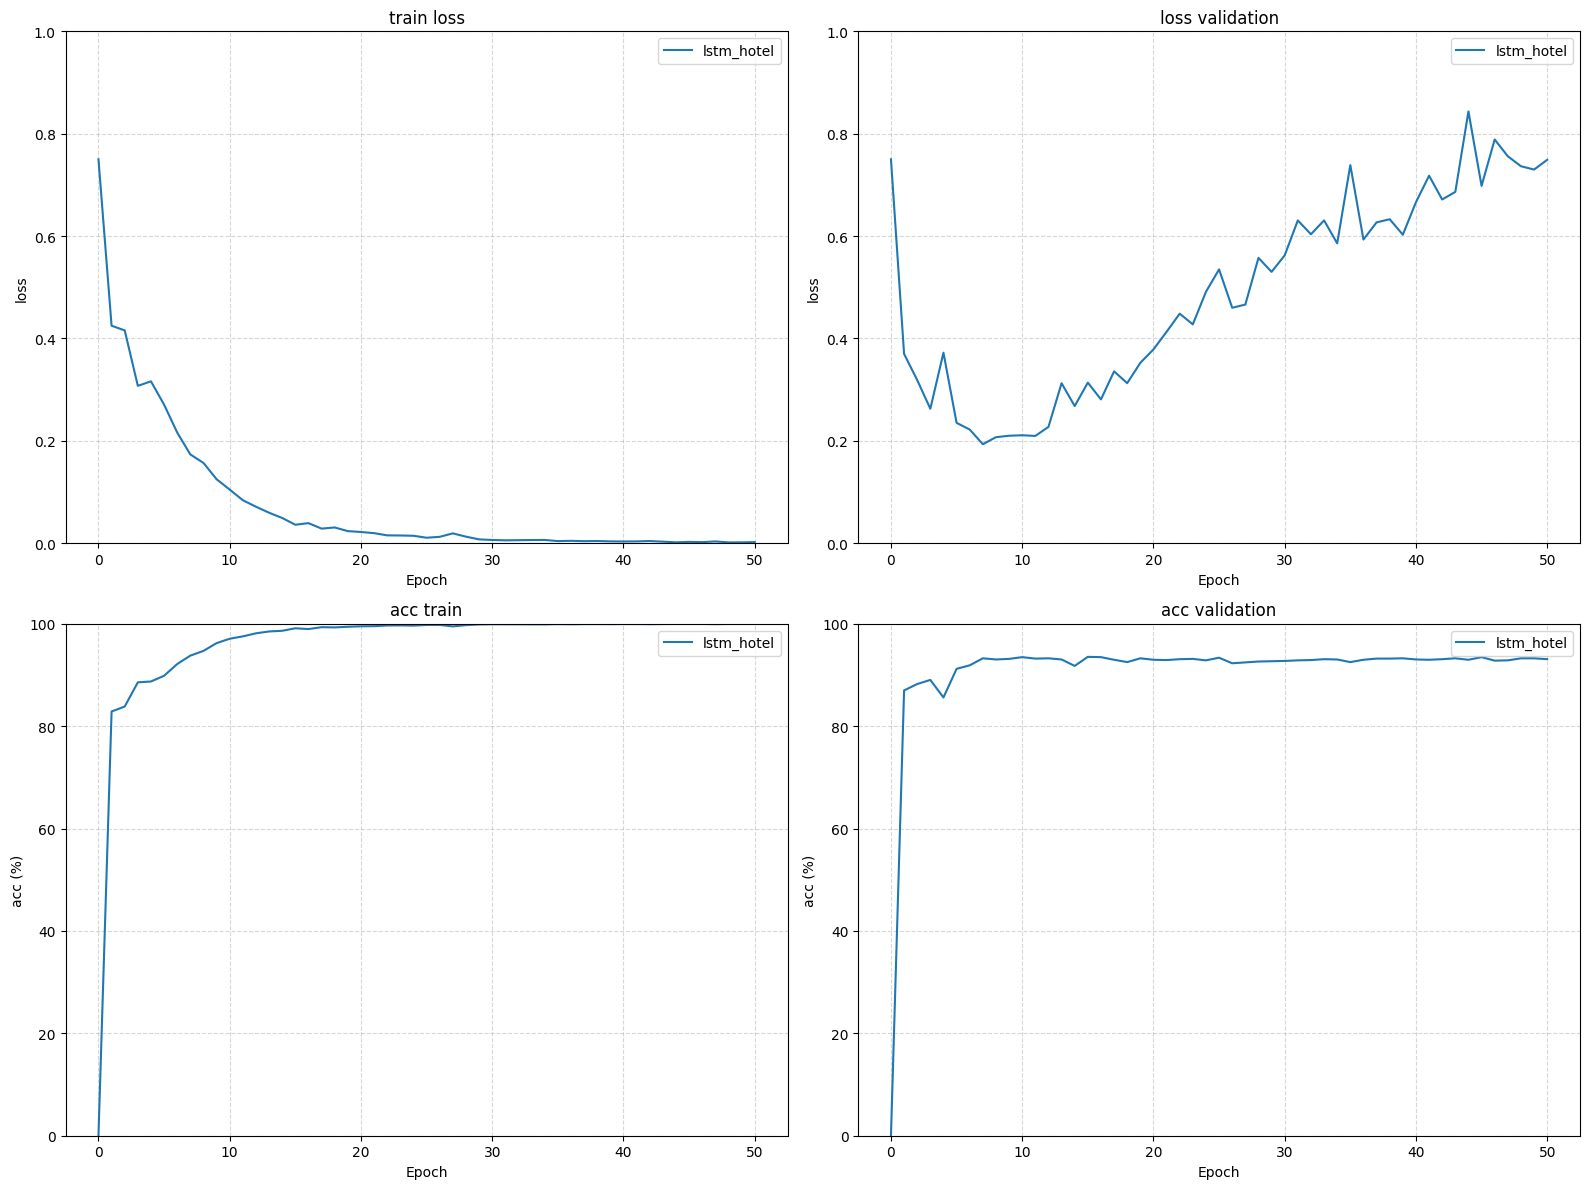

In [81]:
plot_training_curves2(history_hotel_lstm, 'lstm_hotel')


In [71]:
model_lstm

BiLSTM_Attn(
  (embedding): Embedding(30522, 32, padding_idx=0)
  (lstm): LSTM(32, 32, batch_first=True, bidirectional=True)
  (fc): Linear(in_features=64, out_features=2, bias=True)
  (dropout): Dropout(p=0.7, inplace=False)
)

In [78]:

device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
model_lstm.to(device)

test_true, test_preds, _, _ = evaluate2(model_lstm, device, test_loader_cnn)
accuracy = accuracy_score(test_true, test_preds)
print(f"Test Accuracy: {accuracy * 100:.2f}%\n")

Evaluating: 100%|██████████| 110/110 [00:01<00:00, 106.31it/s]

Test Accuracy: 93.09%



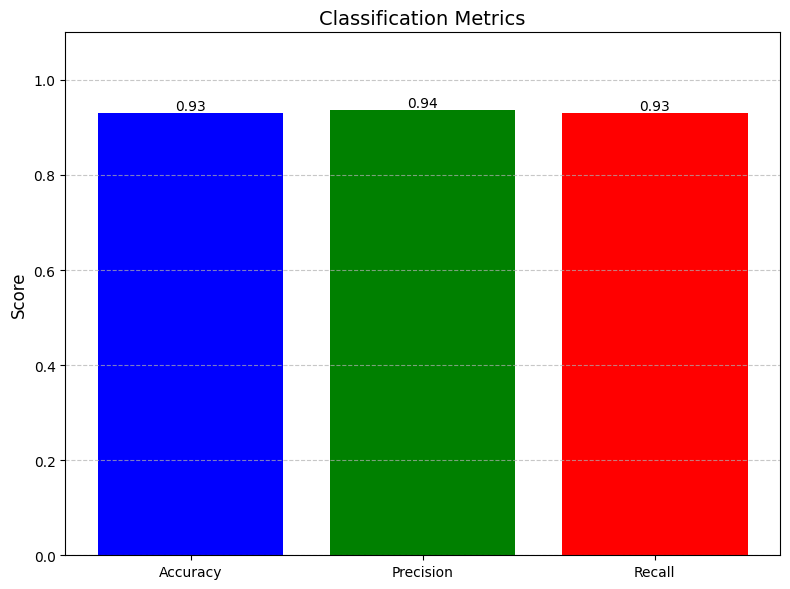

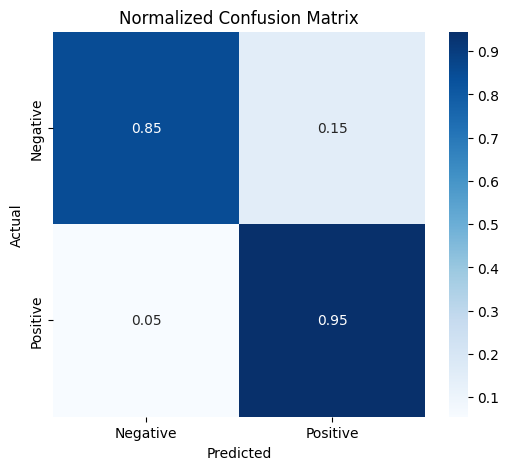

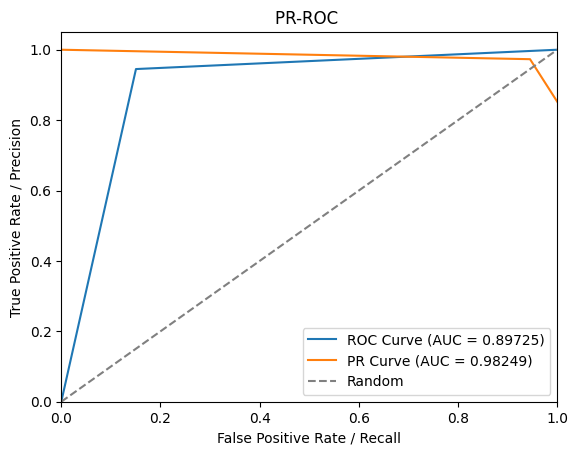

In [79]:
from sklearn.metrics import accuracy_score, precision_score, recall_score, f1_score, classification_report

acc = accuracy_score(test_true, test_preds)
precision = precision_score(test_true, test_preds, average='weighted')  # 或 'micro', 'weighted'
recall = recall_score(test_true, test_preds, average='weighted')
f1 = f1_score(test_true, test_preds, average='weighted')
draw_bar(acc, precision, recall)
plot_confusion_matrix(test_true, test_preds, labels=["Negative", "Positive"])
plot_auc(test_preds, test_true)

## Naive Bayes

In [2]:
param_grid = {
        # 'fit_prior': Categorical([True, False]),
    'alpha': [0.05, 0.1, 0.5, 1.0, 2.0, 3.0]

}
nb_model = MultinomialNB()
grid_search_model(nb_model, X_train_count, X_test_count,
                y_train_count, y_test_count, param_grid=param_grid)

NameError: name 'MultinomialNB' is not defined